In [1]:
from astropy.io import fits
from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from winterdrp_offline.utils import plot_image, write_image, get_table_from_ldac
from winterdrp_offline.image_operations import median_combine_images, normalize_and_median_combine_images, split_data_into_channels, merge_channels_into_data
from winterdrp_offline.astrometry import get_astrometry_header_from_scamped_file
from winterdrp_offline.sextractor import run_sextractor
from winterdrp_offline.scamp import get_tmass_gaia_catalog_for_image
from winterdrp_offline.photcal import xmatch_img_ref_cats, calculate_zeropoint_outlier_rejection
import astropy.units as u
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.background import Background2D

In [2]:
# Set up the directories
base_dir = Path.home() / "Data/observing/winter/"

night = "20250220_C2"
night = "20240309_C2MNLC"

target_dir = base_dir / night / "final"

out_dir = target_dir.parent / "crosscheck"
out_dir.mkdir(exist_ok=True)
# print(base_dir)
# name = 'ZTF25aadlqhw'
# night = '20250220'
# boardid = 4

# target_dir = base_dir.joinpath(f'{name}/{night}/{boardid}/')

In [3]:
raw_list = list(target_dir.glob("*0.fits"))
print(f"Found {len(raw_list)} raw files in {target_dir}")

Found 47 raw files in /Users/rdstein/Data/observing/winter/20240309_C2MNLC/final


Loading /Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-122940-298_mef_4_0_0.fits
(1096, 1984)
(16, 16)


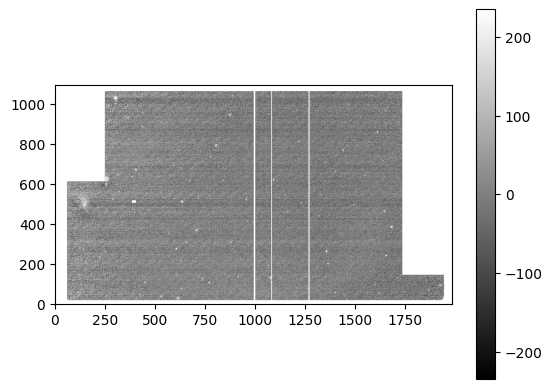

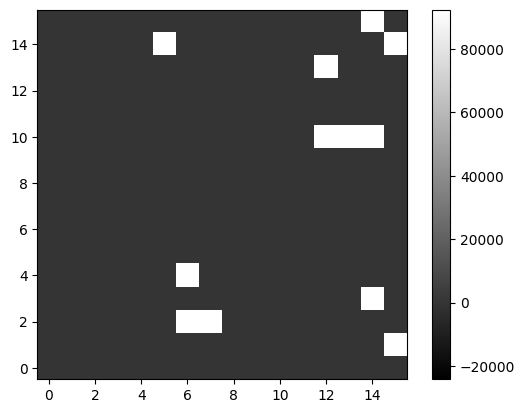

In [4]:
# Load a raw_unpacked file
img_file = raw_list[0]
print(f"Loading {img_file}")
raw_img = fits.getdata(target_dir.joinpath('raw_unpacked', img_file))
from astropy.visualization import ImageNormalize
norm = ImageNormalize(vmin=12000, vmax = 40000)
plot_image(raw_img)

print(raw_img.shape)

roi_center = [312, 1215]
roi_width = 16
roi_height = 16
roi_coords = [roi_center[0] - roi_height//2, roi_center[0] + roi_height//2, roi_center[1] - roi_width//2, roi_center[1] + roi_width//2]
roi = raw_img[roi_coords[0]:roi_coords[1], roi_coords[2]:roi_coords[3]]
# astropy visualization norm:
norm = ImageNormalize(vmin=np.nanmin(raw_img), vmax = np.nanmax(raw_img))
plot_image(roi, norm=norm)
print(roi.shape)

shape of channels: (8, 4)
norm: <astropy.visualization.mpl_normalize.ImageNormalize object at 0x126039f70>


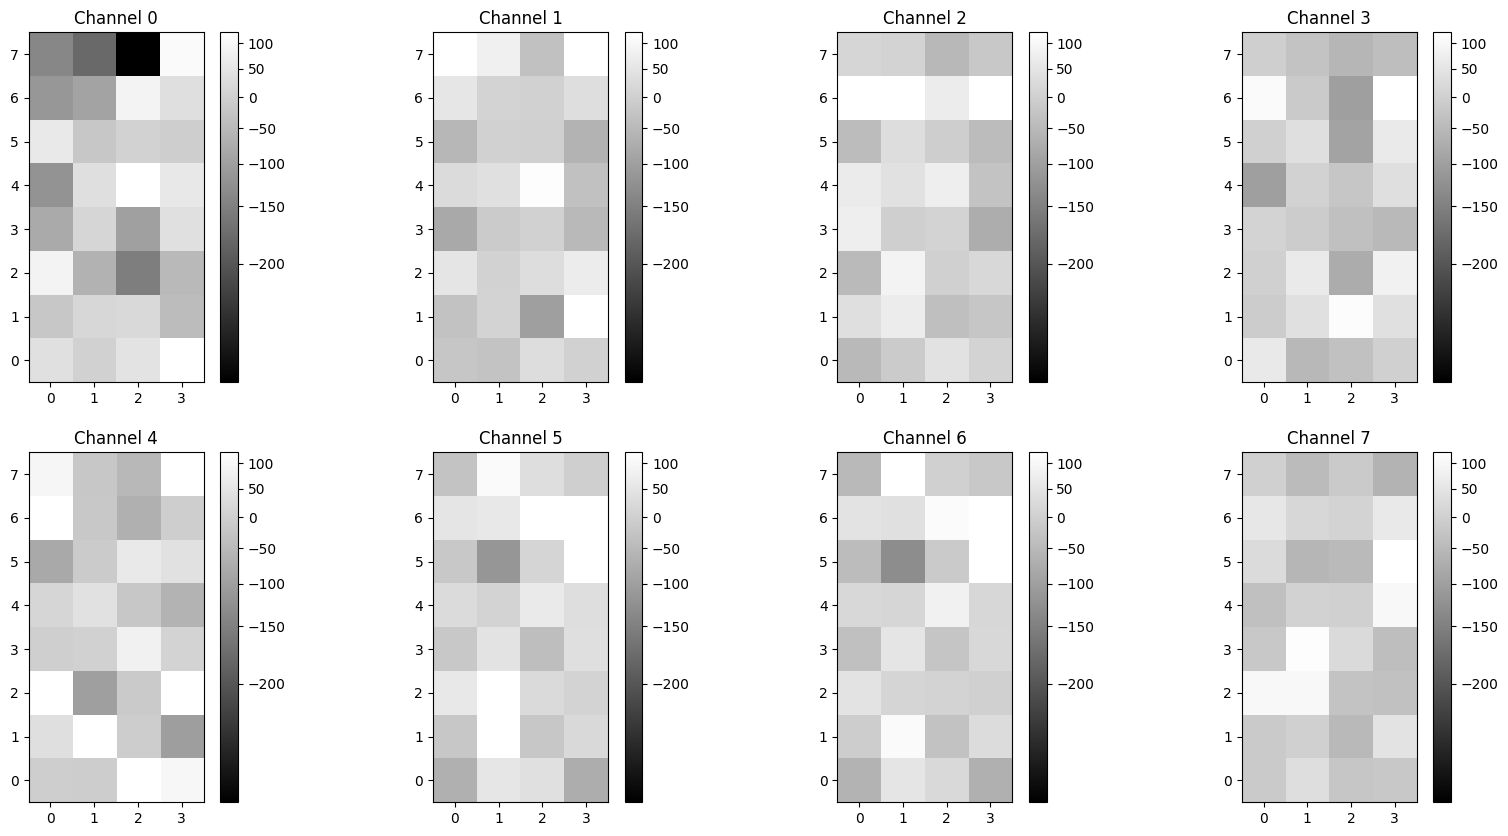

In [5]:
# Split the data up into channels
channels = split_data_into_channels(roi)
print(f"shape of channels: {channels[0].shape}")

# plot all the 8 channels. use the same color scale
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
    # if it's the first image, grab the normalization 
    if i==0:
        ax, norm = plot_image(channels[i], ax=ax, return_norm=True, norm = "zscale")
        print(f"norm: {norm}")
    else:
        plot_image(channels[i], ax=ax, norm=norm)
    ax.set_title(f"Channel {i}")
    

plt.show()




In [6]:
# Run sextractor on the skysubtracted image. With regions=True, a regions file
# with all detected sources is written in the target directory.

def get_xmatch_catalog(path: Path):
    image_catalog = get_table_from_ldac(path)
    image_catalog = image_catalog[(image_catalog['MAG_AUTO'] < 99) & (image_catalog['MAG_PSF'] < 99) & (image_catalog['FLAGS']==0) & (image_catalog['FWHM_WORLD']<4.0/3600.0)]
    print(f"Found {len(image_catalog)} good sources in the catalog")

    ref_cat = get_table_from_ldac(path.with_suffix(".local.cat"))
    print(f"Found {len(ref_cat)} good sources in the ref catalog")

    xmatch_cat, xmatch_ref_cat = xmatch_img_ref_cats(image_catalog, ref_cat, xmatch_radius_arcsec=2)
    print(f"Found {len(xmatch_cat)} matched sources")

    return xmatch_cat, xmatch_ref_cat

APER_RANGE = list(range(2, 9))

def get_all_xmatch_cats(parent_dir: Path):
    res = dict()
    all_zps = dict()
    
    cats = list(parent_dir.glob("WINTER*0.cat"))
    for cat in cats:
        (new, ref) = get_xmatch_catalog(cat)

        for i in APER_RANGE:
            new[f"MAG_APER_{i}"] = [x[i-2] for x in new["MAG_APER"]]
            new[f"FLUX_APER_{i}"] = [x[i-2] for x in new["FLUX_APER"]]

        res[cat.name] = (new, ref)
        

        path = cat.parent.parent / "final" / cat.with_suffix(".fits").name

        with fits.open(path) as hdul:
            all_zps[cat.name] = hdul[0].header["ZP"]
    
        

    return res, all_zps
    
# catname = run_sextractor(skysub_scamped_filename, weightimg=None, regions=True)

In [7]:
all_xmatch, all_zps = get_all_xmatch_cats(target_dir.parent / "phot")

Found 154 good sources in the catalog
Found 141 good sources in the ref catalog
Found 67 matched sources
Found 1506 good sources in the catalog
Found 148 good sources in the ref catalog
Found 51 matched sources
Found 154 good sources in the catalog
Found 140 good sources in the ref catalog
Found 70 matched sources
Found 1044 good sources in the catalog
Found 141 good sources in the ref catalog
Found 60 matched sources
Found 1996 good sources in the catalog
Found 147 good sources in the ref catalog
Found 52 matched sources


Found 155 good sources in the catalog
Found 141 good sources in the ref catalog
Found 62 matched sources
Found 131 good sources in the catalog
Found 141 good sources in the ref catalog
Found 57 matched sources
Found 202 good sources in the catalog
Found 140 good sources in the ref catalog
Found 72 matched sources
Found 218 good sources in the catalog
Found 147 good sources in the ref catalog
Found 60 matched sources
Found 111 good sources in the catalog
Found 147 good sources in the ref catalog
Found 60 matched sources
Found 149 good sources in the catalog
Found 143 good sources in the ref catalog
Found 67 matched sources
Found 872 good sources in the catalog


Found 146 good sources in the ref catalog
Found 55 matched sources
Found 732 good sources in the catalog
Found 141 good sources in the ref catalog
Found 58 matched sources
Found 199 good sources in the catalog
Found 146 good sources in the ref catalog
Found 65 matched sources
Found 185 good sources in the catalog
Found 147 good sources in the ref catalog
Found 57 matched sources
Found 170 good sources in the catalog
Found 145 good sources in the ref catalog
Found 60 matched sources
Found 934 good sources in the catalog
Found 139 good sources in the ref catalog
Found 63 matched sources
Found 157 good sources in the catalog


Found 141 good sources in the ref catalog
Found 53 matched sources
Found 1698 good sources in the catalog
Found 144 good sources in the ref catalog
Found 46 matched sources
Found 141 good sources in the catalog
Found 144 good sources in the ref catalog
Found 68 matched sources
Found 211 good sources in the catalog
Found 142 good sources in the ref catalog
Found 53 matched sources
Found 176 good sources in the catalog
Found 147 good sources in the ref catalog
Found 59 matched sources
Found 125 good sources in the catalog
Found 142 good sources in the ref catalog
Found 60 matched sources
Found 1650 good sources in the catalog


Found 147 good sources in the ref catalog
Found 46 matched sources
Found 179 good sources in the catalog
Found 141 good sources in the ref catalog
Found 63 matched sources
Found 138 good sources in the catalog
Found 146 good sources in the ref catalog
Found 51 matched sources
Found 861 good sources in the catalog
Found 147 good sources in the ref catalog
Found 56 matched sources
Found 147 good sources in the catalog
Found 142 good sources in the ref catalog
Found 61 matched sources
Found 780 good sources in the catalog
Found 143 good sources in the ref catalog
Found 54 matched sources


Found 2616 good sources in the catalog
Found 147 good sources in the ref catalog
Found 33 matched sources
Found 139 good sources in the catalog
Found 147 good sources in the ref catalog
Found 61 matched sources
Found 105 good sources in the catalog
Found 142 good sources in the ref catalog
Found 64 matched sources
Found 231 good sources in the catalog
Found 144 good sources in the ref catalog
Found 56 matched sources
Found 1063 good sources in the catalog
Found 143 good sources in the ref catalog
Found 57 matched sources
Found 1751 good sources in the catalog
Found 139 good sources in the ref catalog
Found 45 matched sources


Found 132 good sources in the catalog
Found 146 good sources in the ref catalog
Found 62 matched sources
Found 752 good sources in the catalog
Found 149 good sources in the ref catalog
Found 51 matched sources
Found 272 good sources in the catalog
Found 143 good sources in the ref catalog
Found 55 matched sources
Found 139 good sources in the catalog
Found 143 good sources in the ref catalog
Found 53 matched sources
Found 235 good sources in the catalog
Found 143 good sources in the ref catalog
Found 65 matched sources
Found 267 good sources in the catalog
Found 142 good sources in the ref catalog
Found 71 matched sources
Found 193 good sources in the catalog


Found 142 good sources in the ref catalog
Found 65 matched sources
Found 182 good sources in the catalog
Found 141 good sources in the ref catalog
Found 61 matched sources
Found 2449 good sources in the catalog
Found 142 good sources in the ref catalog
Found 27 matched sources
Found 1580 good sources in the catalog
Found 144 good sources in the ref catalog
Found 48 matched sources
Found 171 good sources in the catalog
Found 145 good sources in the ref catalog
Found 53 matched sources
Found 213 good sources in the catalog
Found 143 good sources in the ref catalog
Found 67 matched sources


In [8]:
all_zps

{'WINTERcamera_20240310-073041-109_mef_4_0_0.cat': 25.873673484548107,
 'WINTERcamera_20240310-101904-287_mef_4_0_0.cat': 25.890394423184137,
 'WINTERcamera_20240310-123601-940_mef_4_0_0.cat': 25.814401639058108,
 'WINTERcamera_20240310-112159-183_mef_4_0_0.cat': 25.98354284116205,
 'WINTERcamera_20240310-063518-784_mef_4_0_0.cat': 26.015101451491503,
 'WINTERcamera_20240310-111536-167_mef_4_0_0.cat': 25.996067749892397,
 'WINTERcamera_20240310-073249-188_mef_4_0_0.cat': 25.87929355095312,
 'WINTERcamera_20240310-111744-230_mef_4_0_0.cat': 26.062721786189485,
 'WINTERcamera_20240310-064142-218_mef_4_0_0.cat': 25.89304648976886,
 'WINTERcamera_20240310-063104-528_mef_4_0_0.cat': 25.998980763753817,
 'WINTERcamera_20240310-125525-950_mef_4_0_0.cat': 25.763966574620564,
 'WINTERcamera_20240310-111951-286_mef_4_0_0.cat': 26.0589060265043,
 'WINTERcamera_20240310-123355-104_mef_4_0_0.cat': 26.228399408958207,
 'WINTERcamera_20240310-124016-049_mef_4_0_0.cat': 25.766418369836963,
 'WINTERcam

# MAG_AUTO

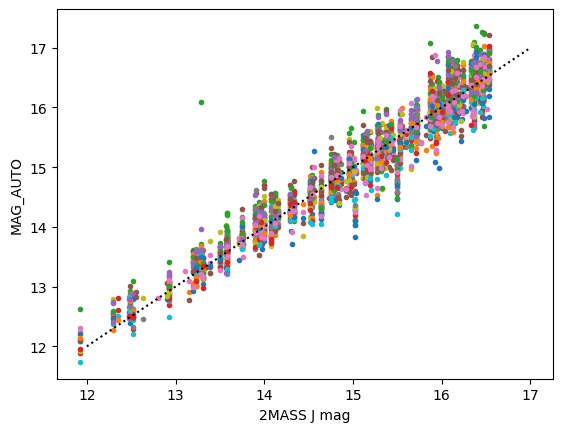

In [9]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key]
    plt.plot(ref['j_m'], cat['MAG_AUTO'] + zp, '.')
plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
plt.ylabel('MAG_AUTO')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_auto.pdf")

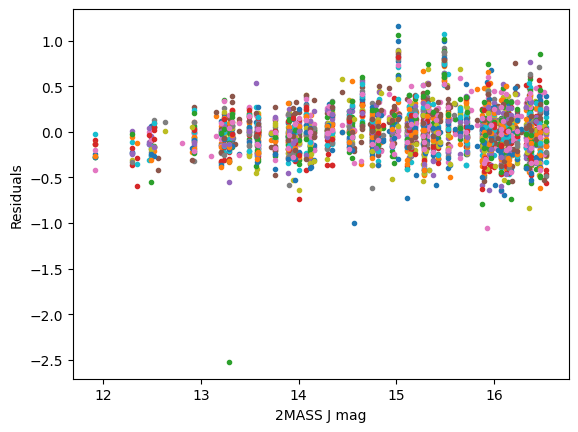

In [10]:
res_df = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_AUTO'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_AUTO'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df = pd.DataFrame(res_df)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_auto.pdf")

Median: 0.00, std: 0.25 
 ZP: 25.90, zpstd 0.07, nstars: 1214


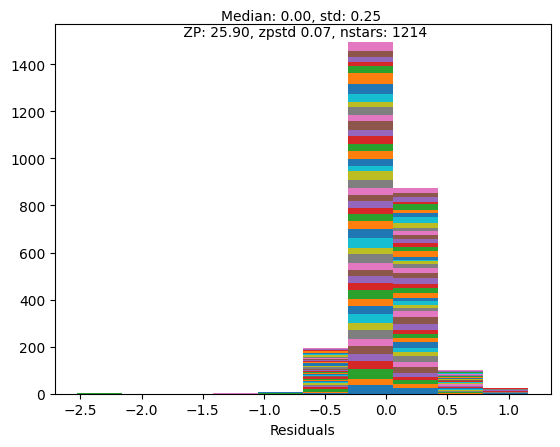

In [11]:
plt.hist(res_df["residuals"], stacked=True,)
all_residuals = [x for y in res_df["residuals"]for x in y]

txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df["zp"].median():.2f}, zpstd {res_df["zpstd"].median():.2f}, nstars: {res_df["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_auto.pdf",
    bbox_inches="tight",
)

# MAG_PSF

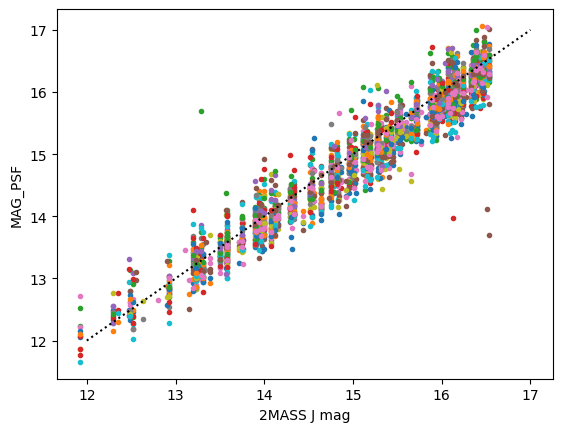

In [12]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key] - 0.3
    plt.plot(ref['j_m'], cat['MAG_PSF'] + zp, '.')

plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
plt.ylabel('MAG_PSF')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_psf.pdf")

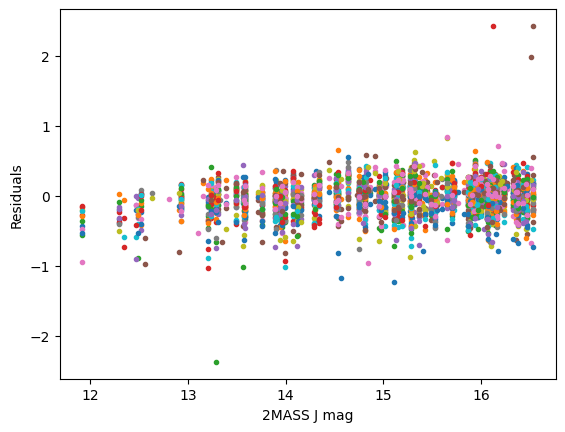

In [13]:
res_df_psf = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_PSF'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_PSF'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df_psf.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df_psf = pd.DataFrame(res_df_psf)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_psf.pdf")

Median: -0.01, std: 0.24 
 ZP: 25.77, zpstd 0.06, nstars: 1262


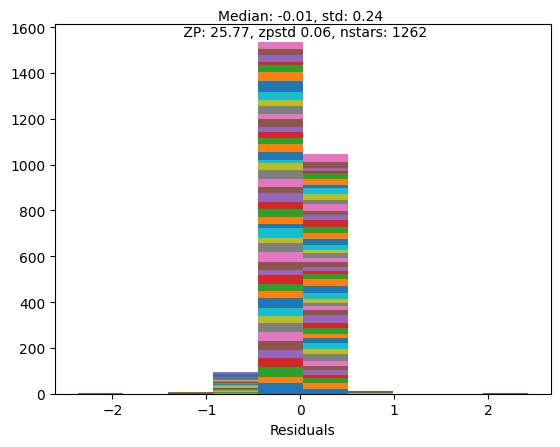

In [14]:
plt.hist(res_df_psf["residuals"], stacked=True)
all_residuals = [x for y in res_df_psf["residuals"] for x in y]
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_psf["zp"].median():.2f}, zpstd {res_df_psf["zpstd"].median():.2f}, nstars: {res_df_psf["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_psf.pdf",
    bbox_inches="tight",
)

# MAG_APER

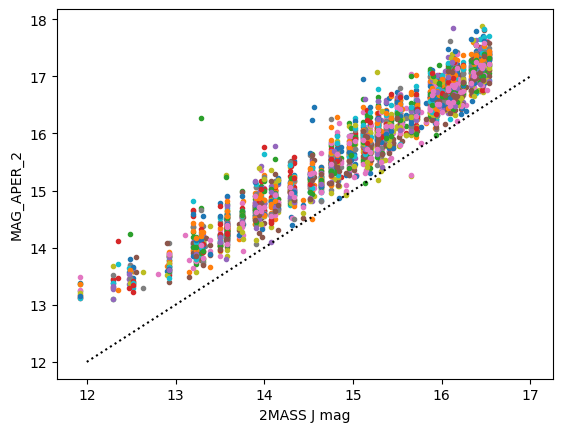

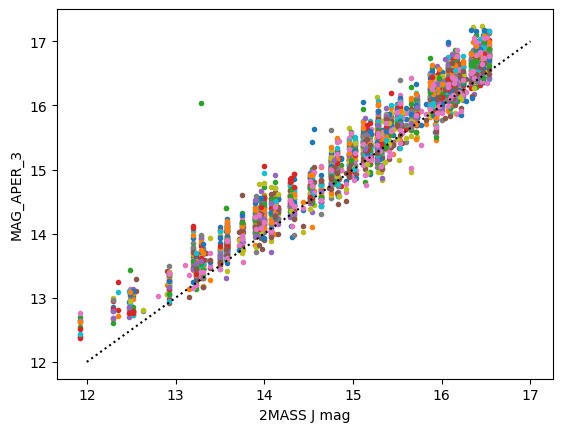

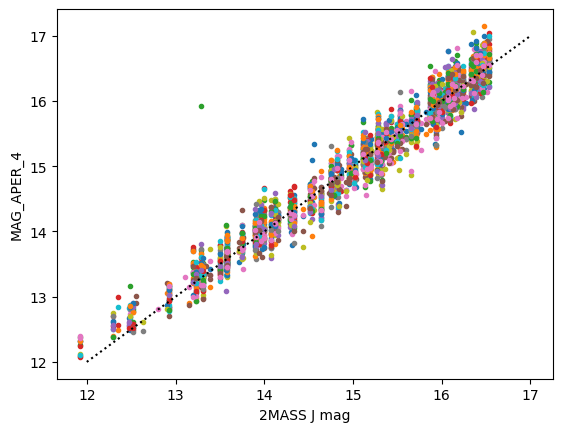

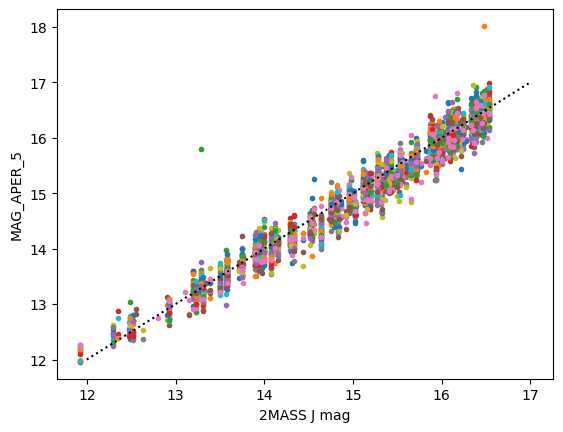

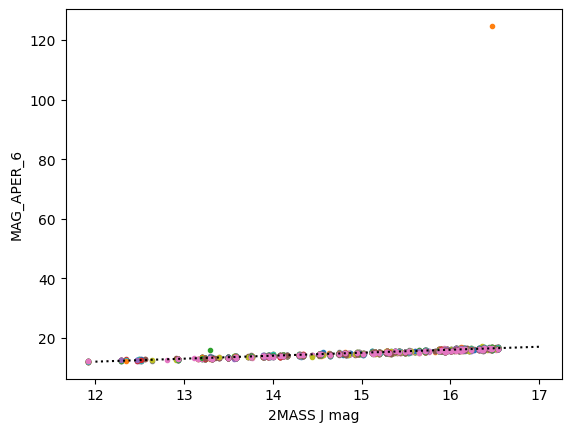

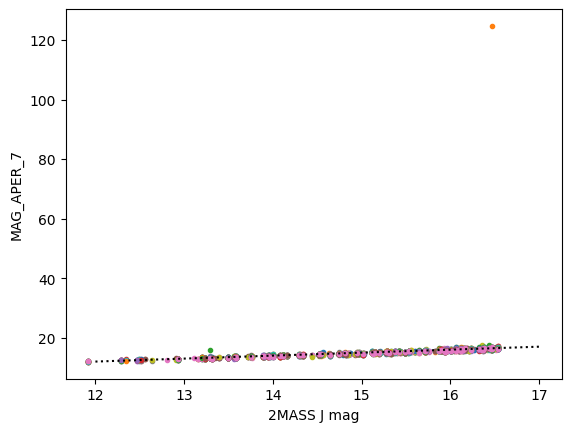

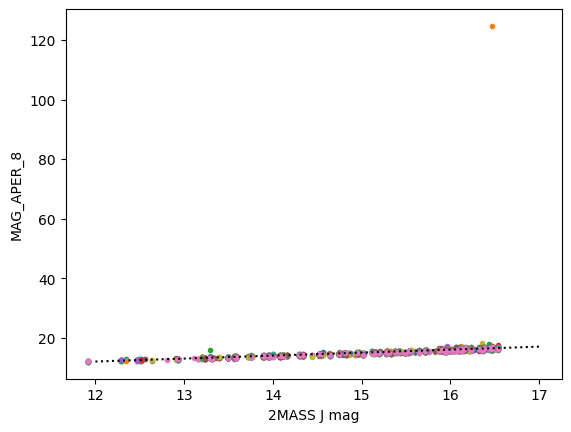

In [15]:
for key in APER_RANGE:
    plt.figure()

    var = f'MAG_APER_{key}'

    for key, (cat, ref) in all_xmatch.items():
        # zp = all_zps[key] - 1.2
        plt.plot(ref['j_m'], cat[var] + zp, '.')
    
    plt.plot([12., 17.], [12., 17.], linestyle=":", color="k")
    
    plt.ylabel(var)
    plt.xlabel('2MASS J mag')
    plt.savefig(out_dir / f"scatter_aper_{key}.pdf")

Median: -0.01, std: 0.24 
 ZP: 25.04, zpstd 0.05, nstars: 1204
Median: -0.00, std: 0.22 
 ZP: 25.51, zpstd 0.06, nstars: 1213
Median: -0.00, std: 0.21 
 ZP: 25.72, zpstd 0.05, nstars: 1208
Median: -0.01, std: 0.22 
 ZP: 25.82, zpstd 0.06, nstars: 1219
Median: -0.01, std: 2.10 
 ZP: 25.87, zpstd 0.06, nstars: 1217
Median: -0.01, std: 2.10 
 ZP: 25.89, zpstd 0.07, nstars: 1210
Median: -0.00, std: 2.10 
 ZP: 25.88, zpstd 0.06, nstars: 1211


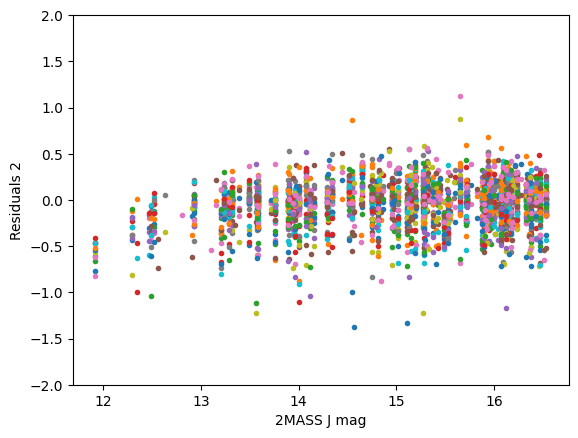

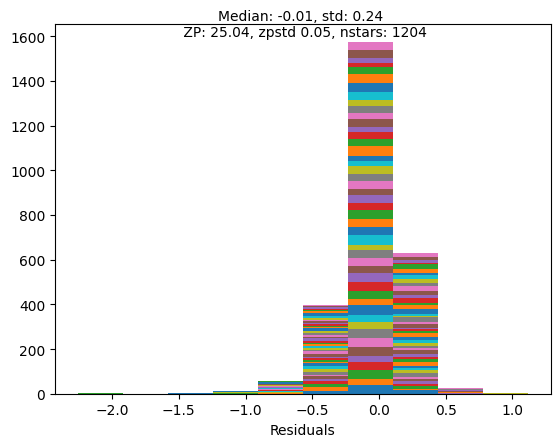

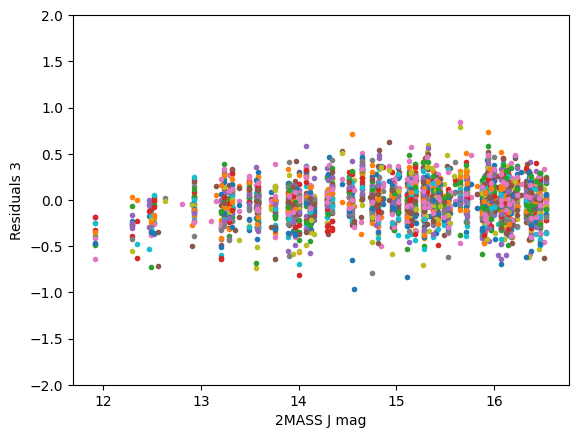

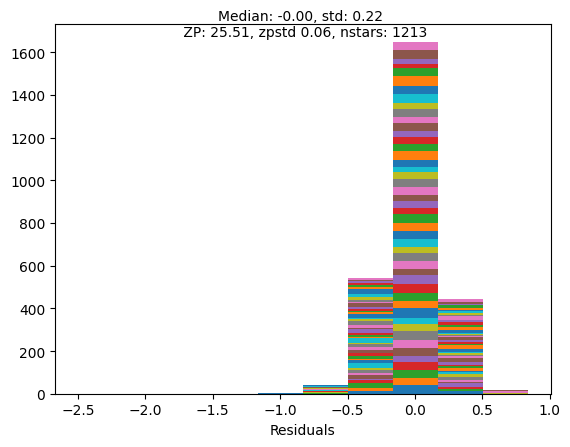

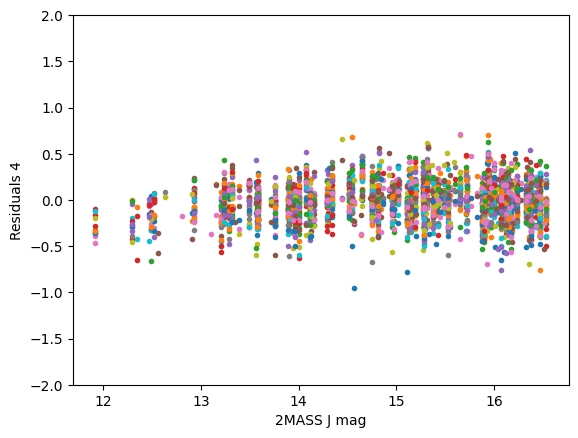

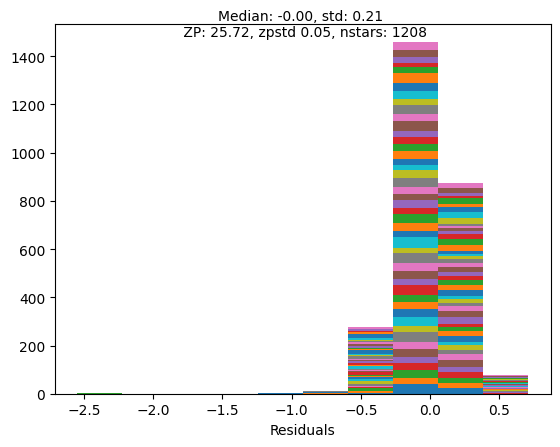

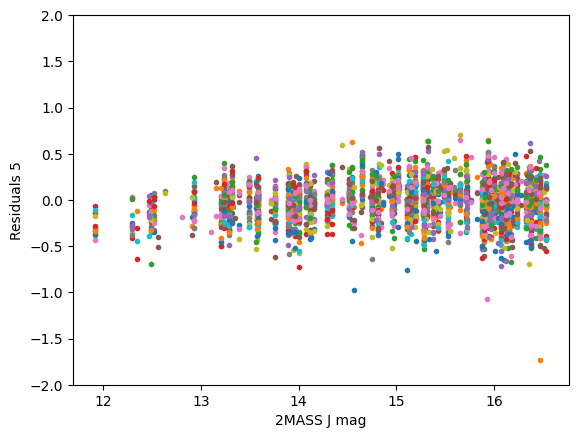

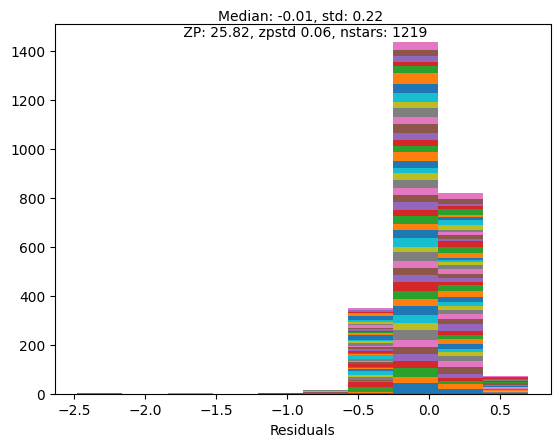

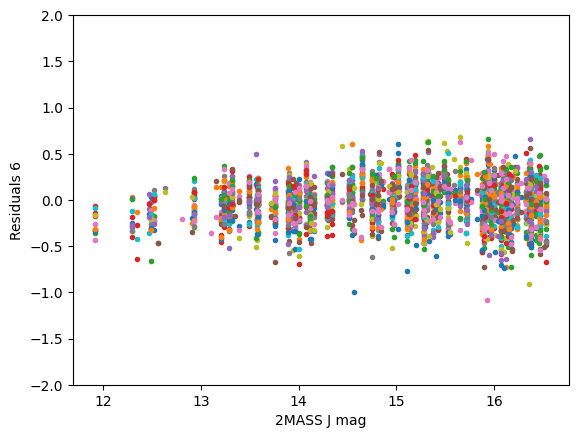

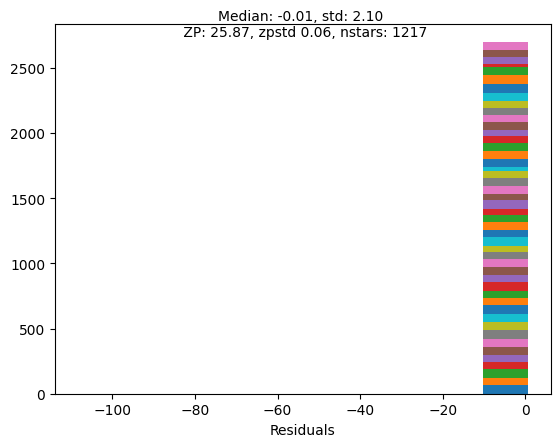

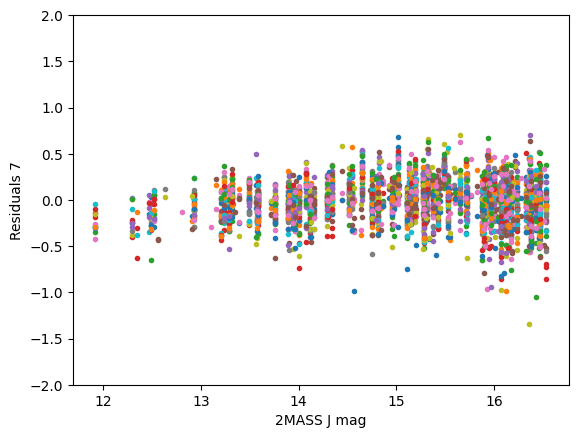

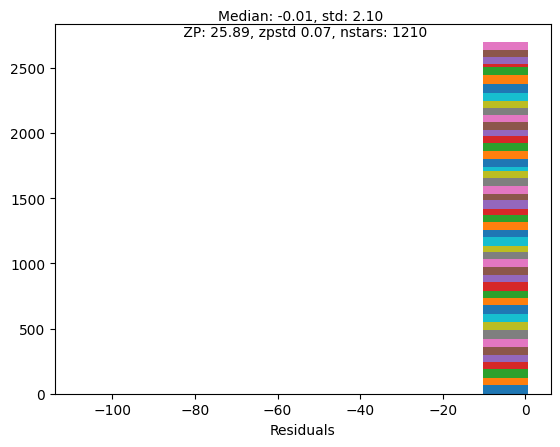

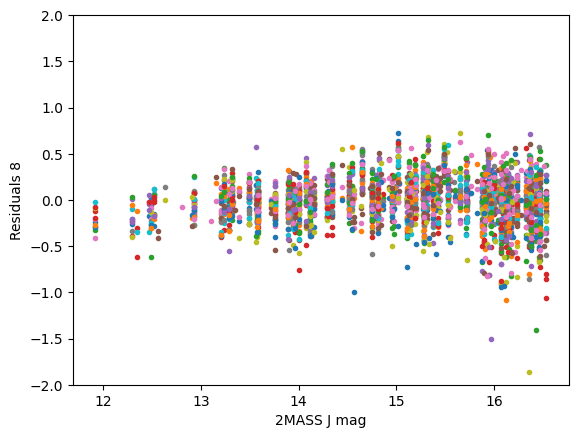

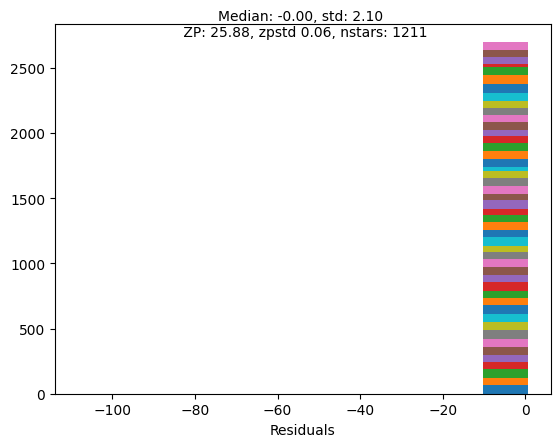

In [16]:
for ap in APER_RANGE:
    plt.figure()

    var = f'MAG_APER_{ap}'

    res_df_aper = []
    
    for key, (cat, ref) in all_xmatch.items():
        
        mags = cat[var]
        zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(mags, ref['j_m'], outlier_rejection_thresholds=[1.5])
        residuals = ref['j_m'] - mags - zp
        plt.plot(ref['j_m'], residuals, '.')
        res_df_aper.append({
            "residuals": [float(x) for x in residuals],
            "zp": zp,
            "zpstd": zpstd,
            "nstars": nstars
        })
        # plt.title(f"{zp:.2f}, {zpstd:.2f}, {key}")
    
    plt.ylabel(f'Residuals {ap}')
    plt.xlabel('2MASS J mag')
    plt.ylim(-2., 2.)
    plt.savefig(out_dir / f"residuals_aper_{ap}.pdf")
    
    res_df_aper = pd.DataFrame(res_df_aper)

    plt.figure()

    plt.hist(res_df_aper["residuals"], stacked=True)
    all_residuals = [x for y in res_df_aper["residuals"] for x in y]
    txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_aper["zp"].median():.2f}, zpstd {res_df_aper["zpstd"].median():.2f}, nstars: {res_df_aper["nstars"].sum()}")
    print(txt)
    plt.annotate(
        txt,
        xy=(0.5, 1.0),
        xycoords='axes fraction',
        ha='center',  
        va='center',
    )
    plt.xlabel("Residuals")
    plt.savefig(
        out_dir / f"hist_aper_{ap}.pdf",
        bbox_inches="tight",
)

# MAG_POINTSOURCE

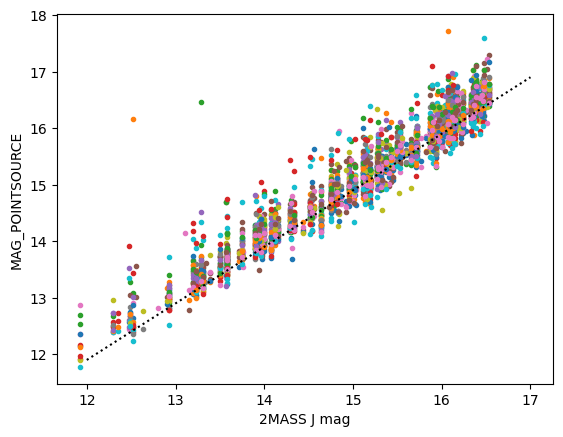

In [17]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key]
    plt.plot(ref['j_m'], cat['MAG_POINTSOURCE'] + zp, '.')

plt.plot([12., 17.], np.array([12., 17.])-0.1, linestyle=":", color="k")
plt.ylabel('MAG_POINTSOURCE')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "scatter_ps.pdf")

In [18]:
def line_fit(x, y):
    """
    Fit a line to the data and return the slope and intercept
    """
    coeffs = np.polyfit(x, y, 1)
    return coeffs[0], coeffs[1]

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_17104/1034904720.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


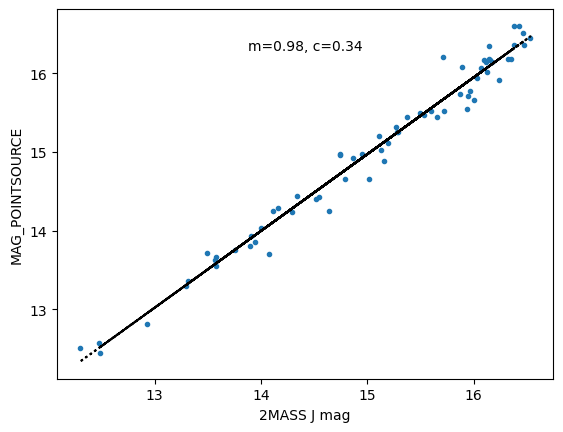

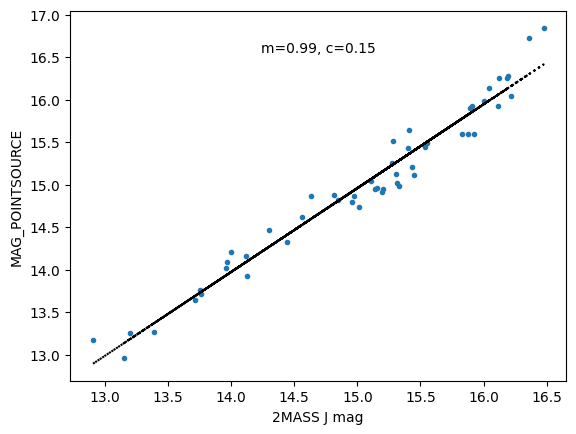

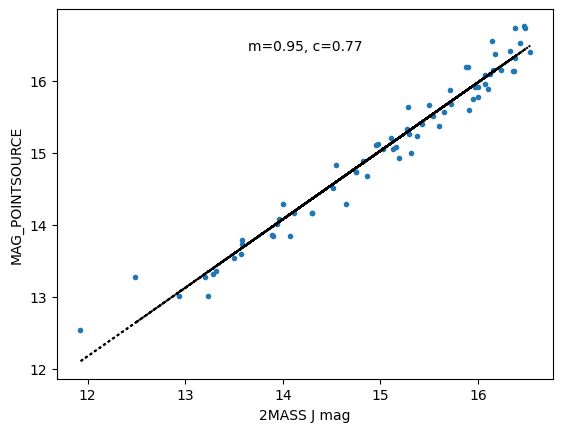

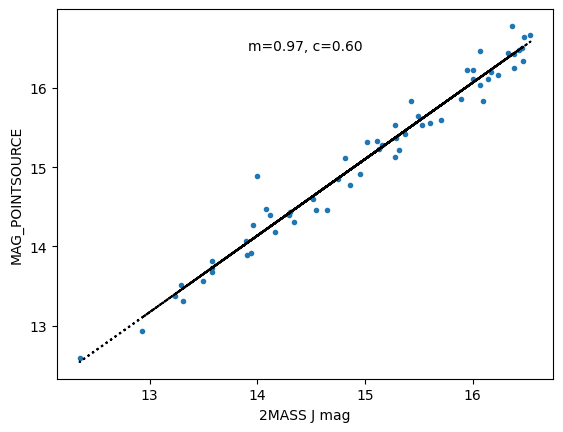

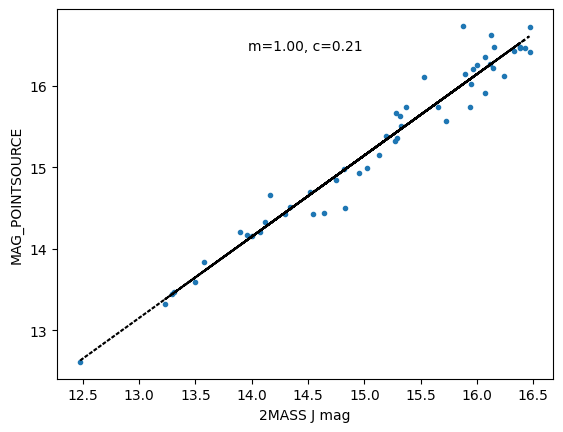

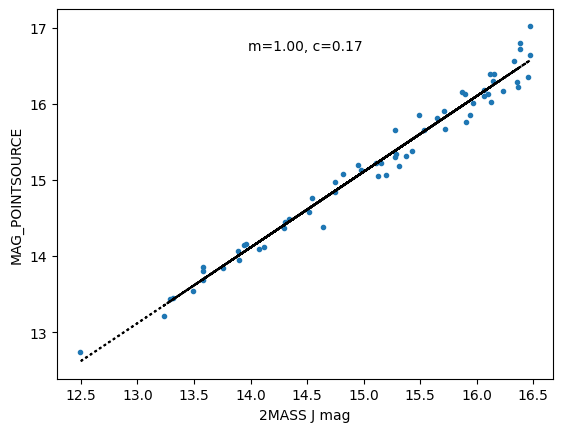

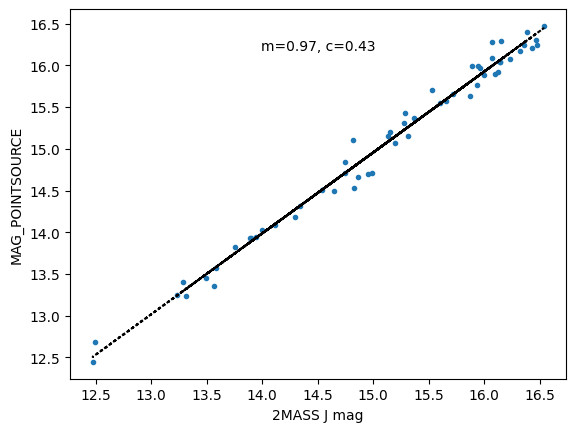

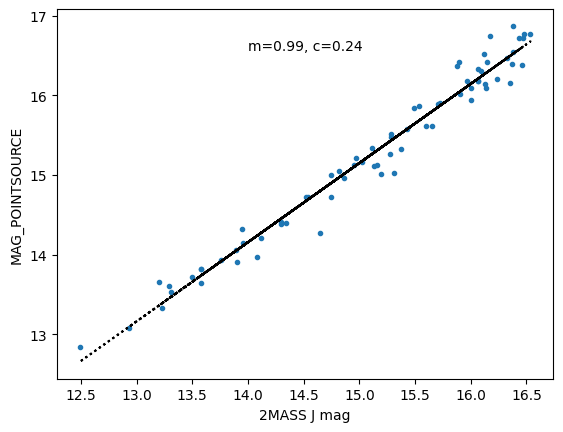

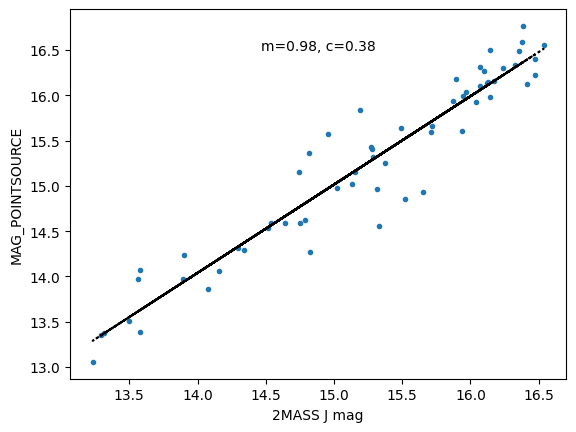

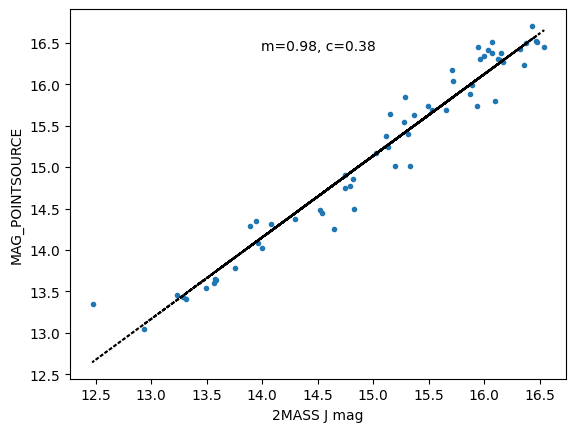

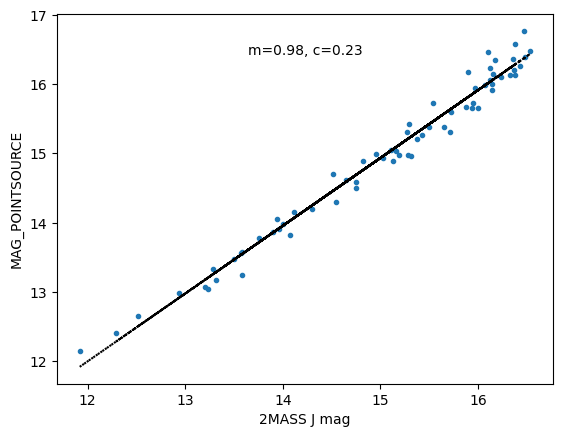

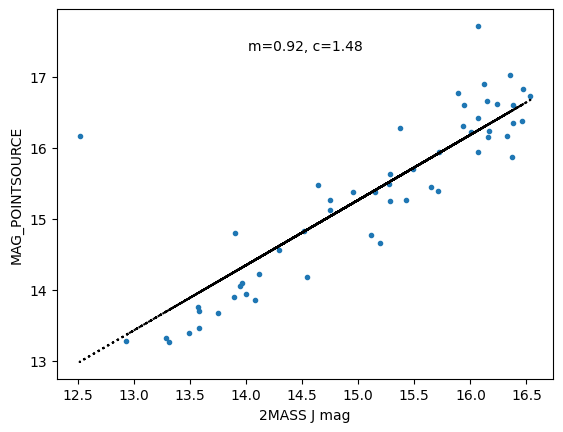

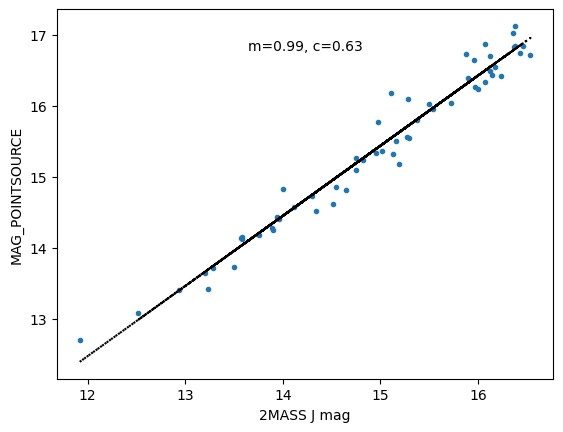

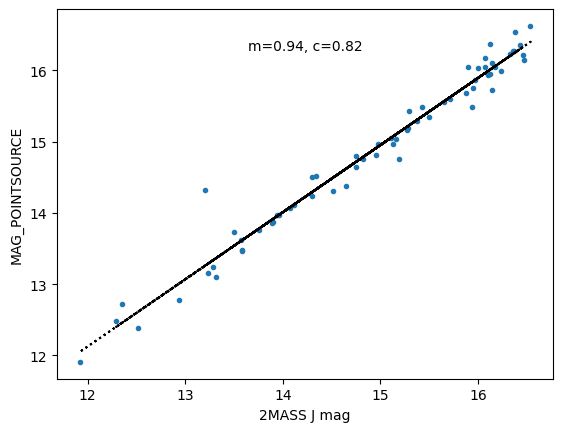

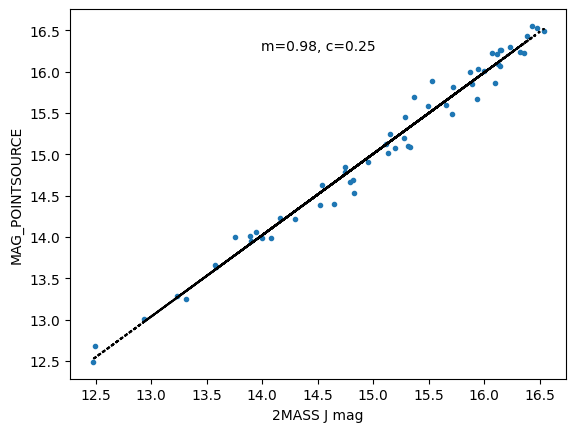

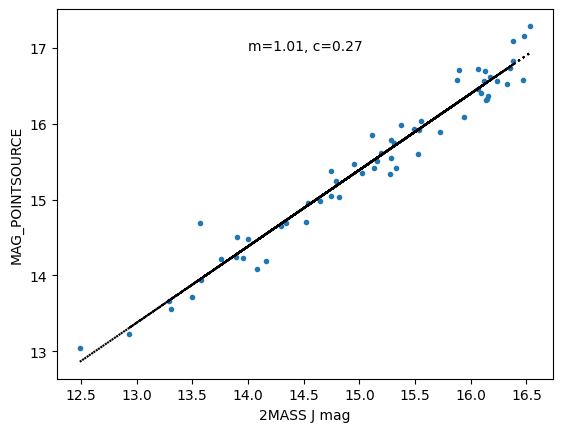

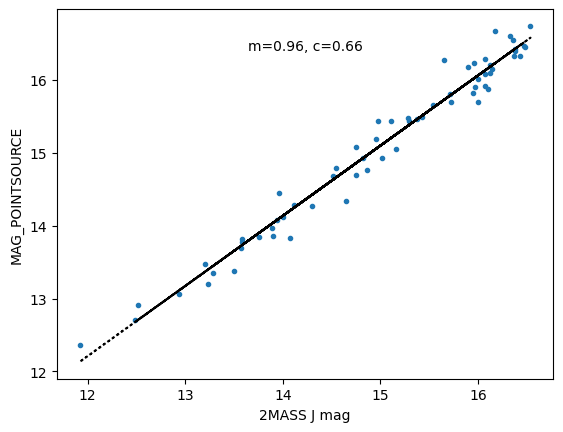

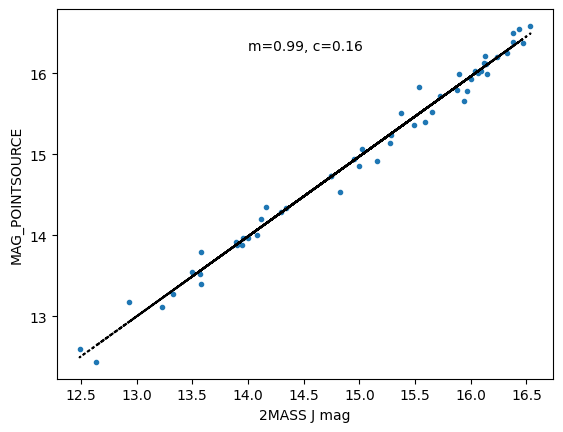

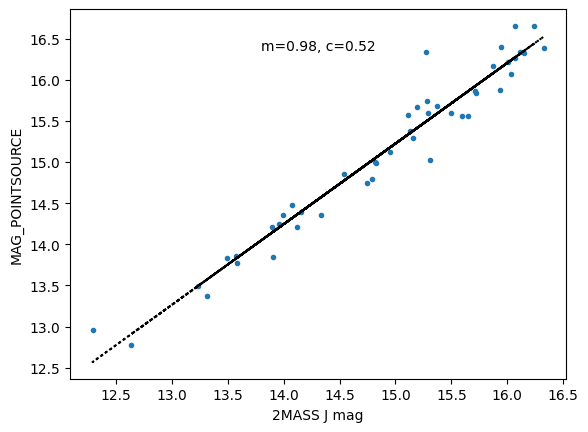

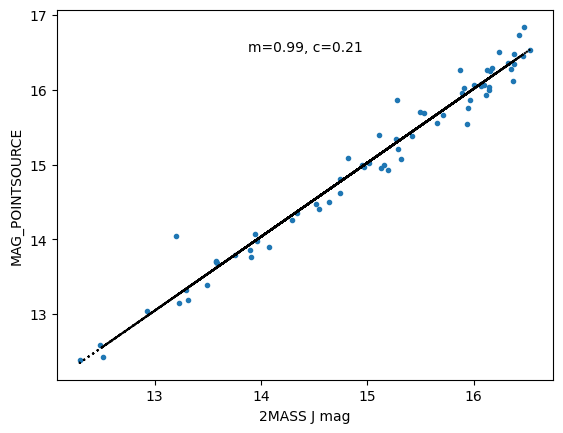

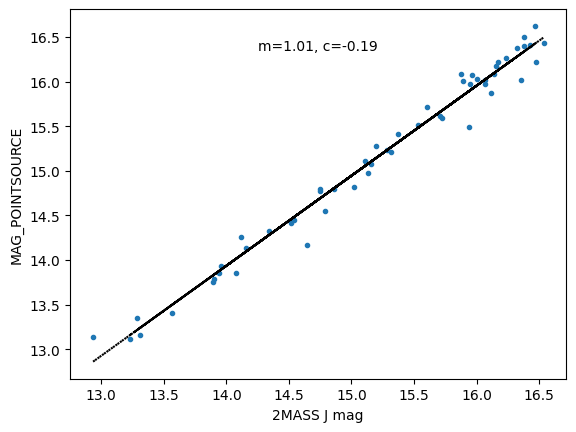

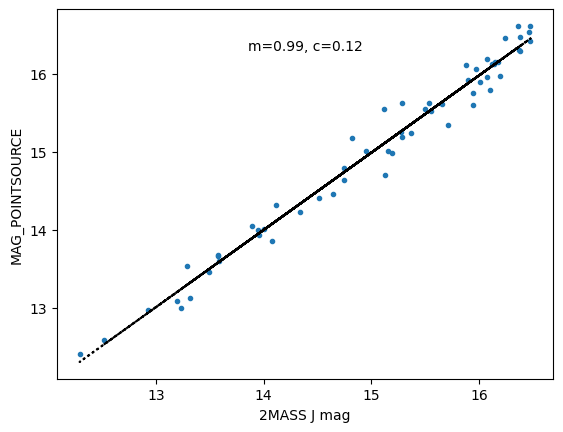

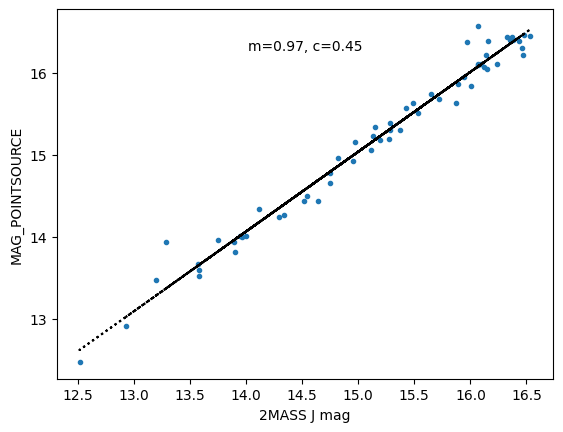

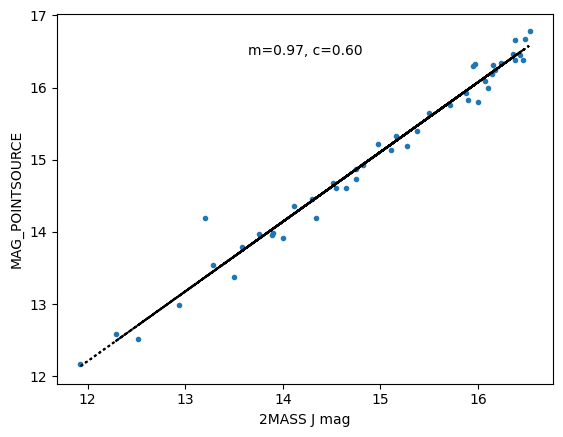

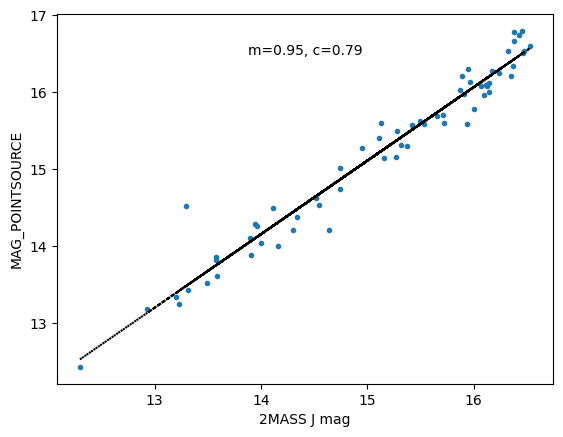

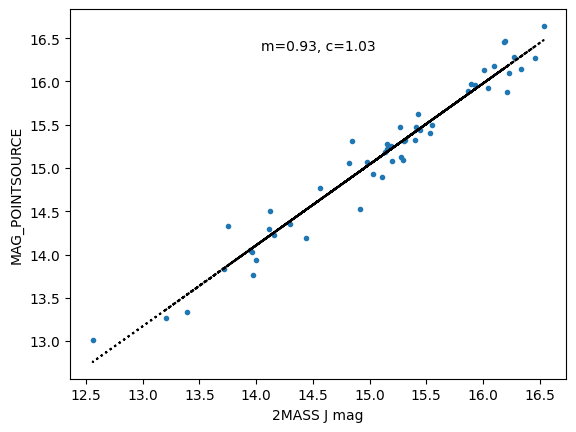

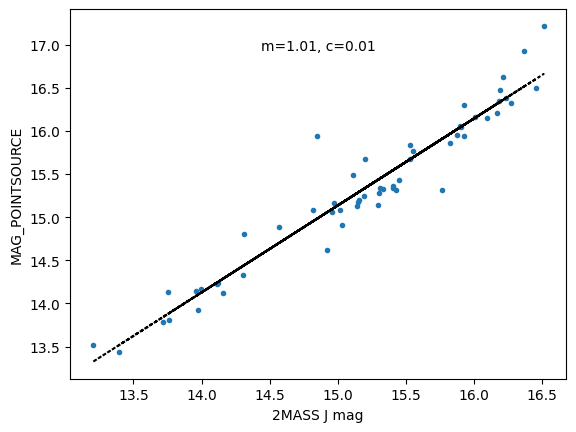

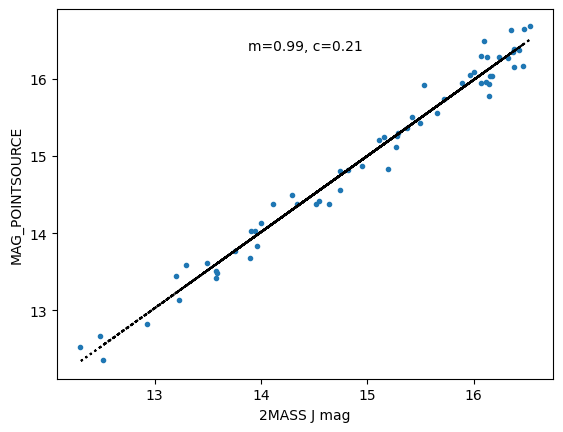

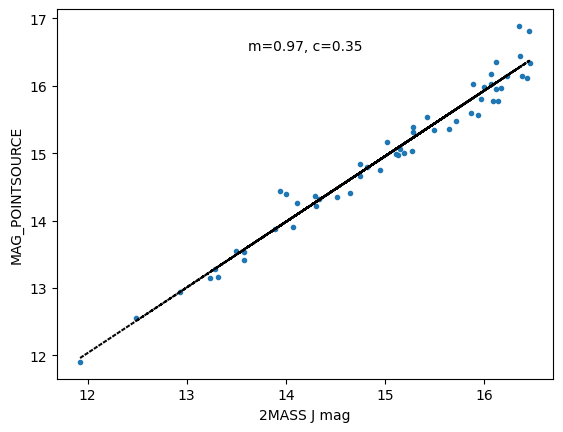

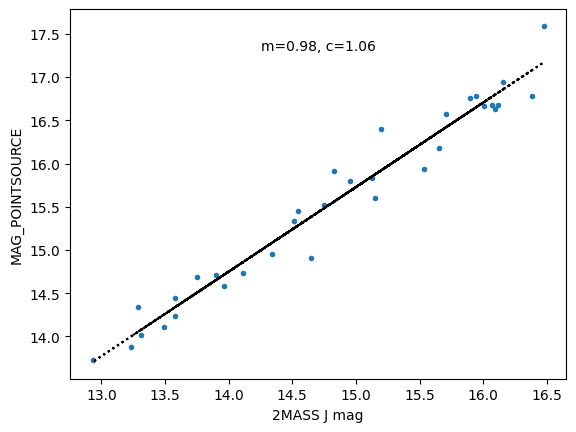

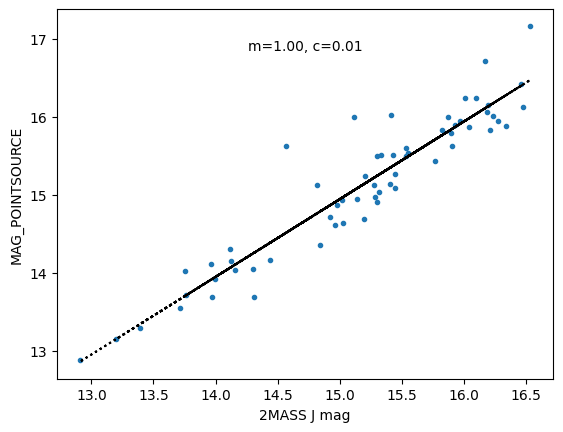

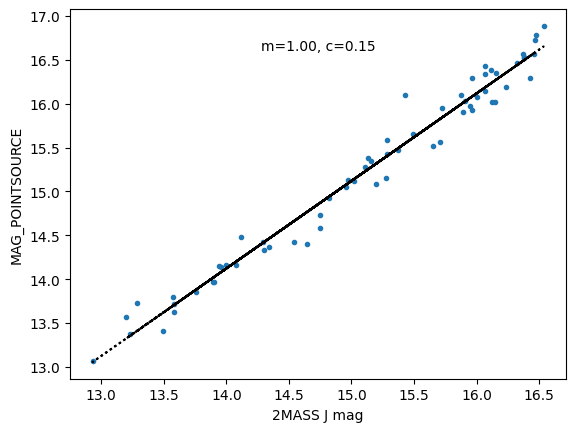

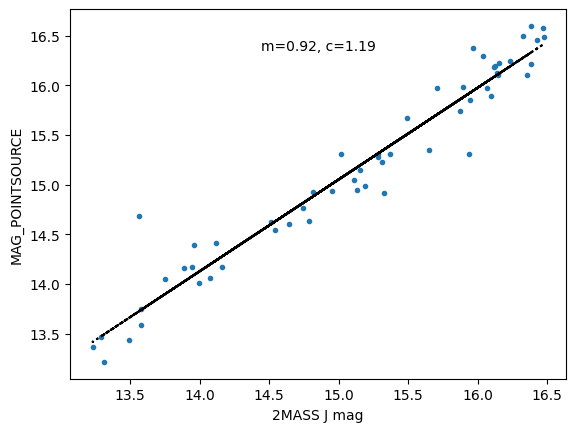

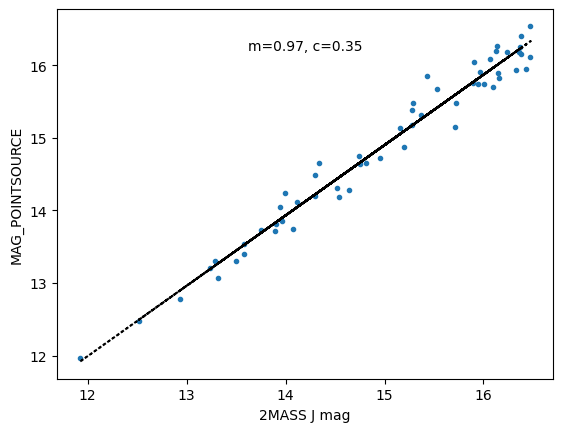

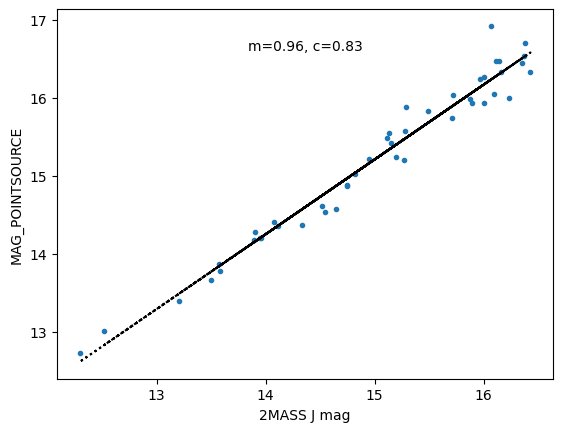

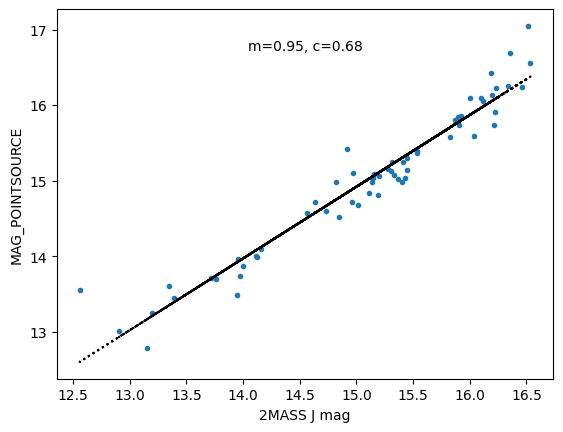

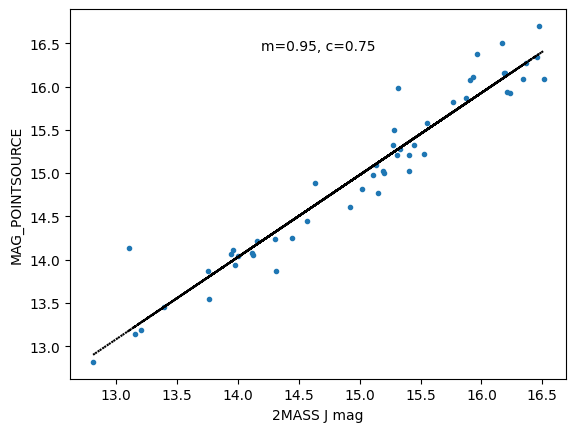

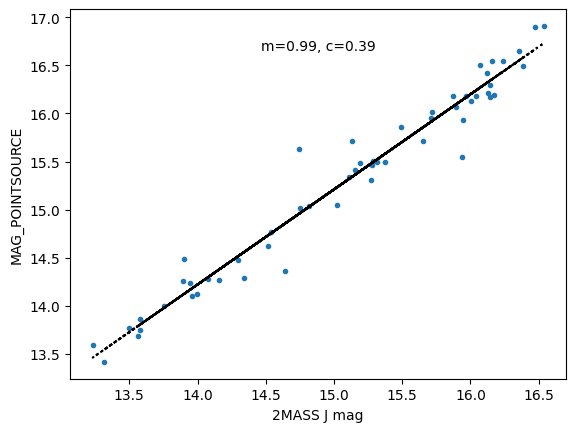

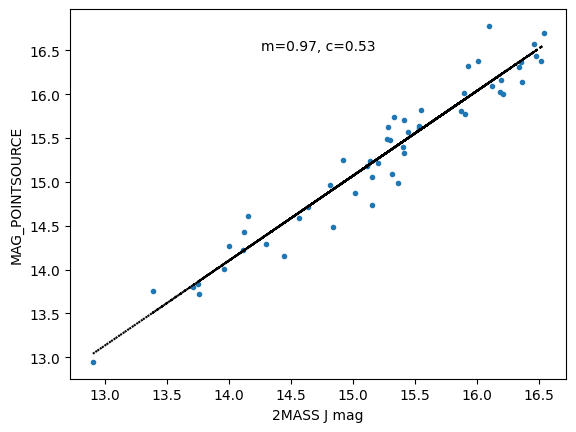

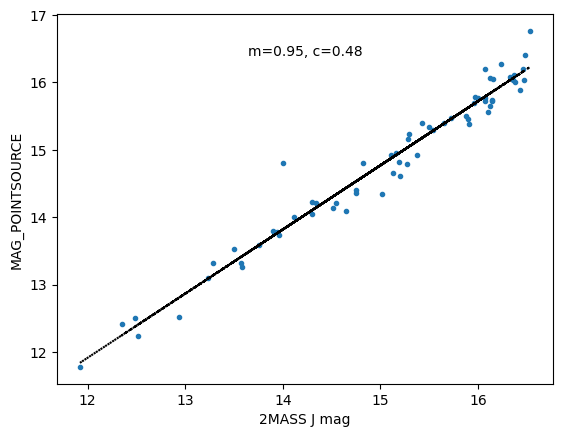

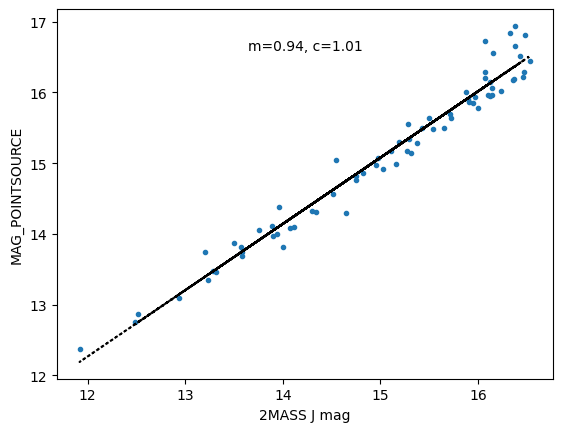

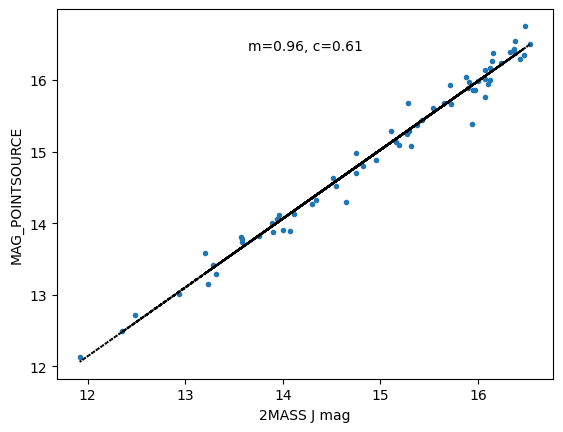

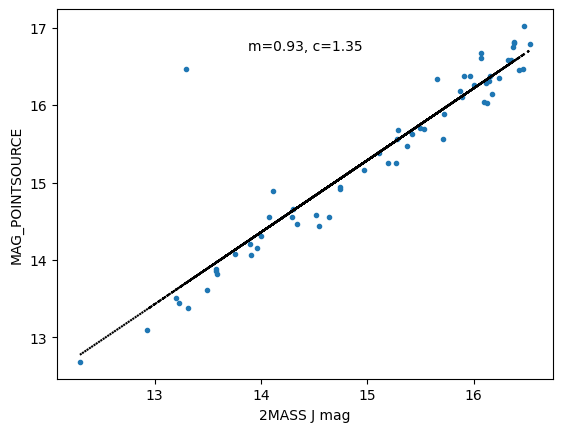

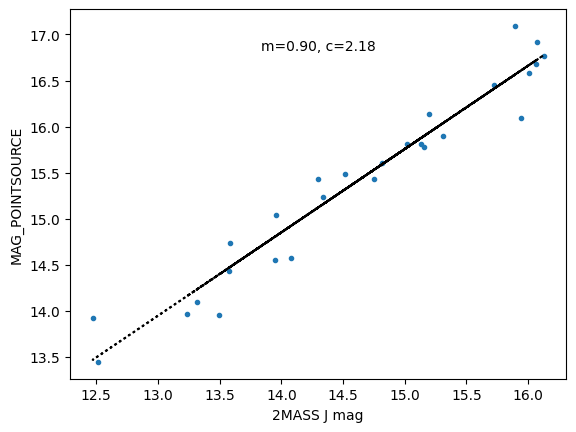

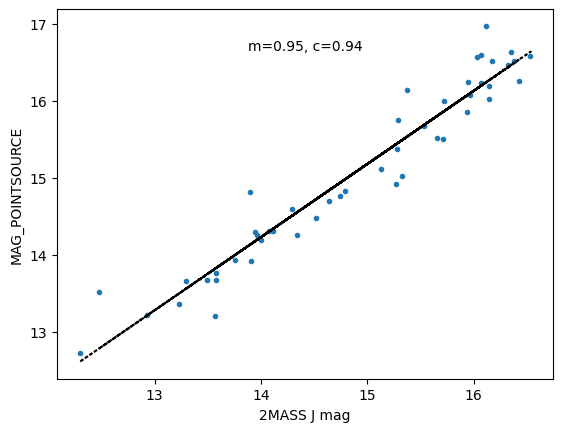

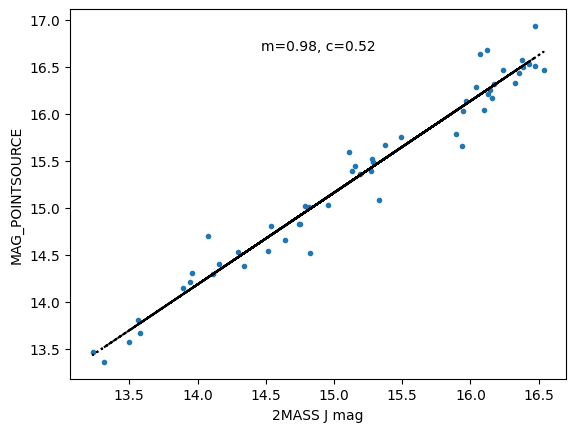

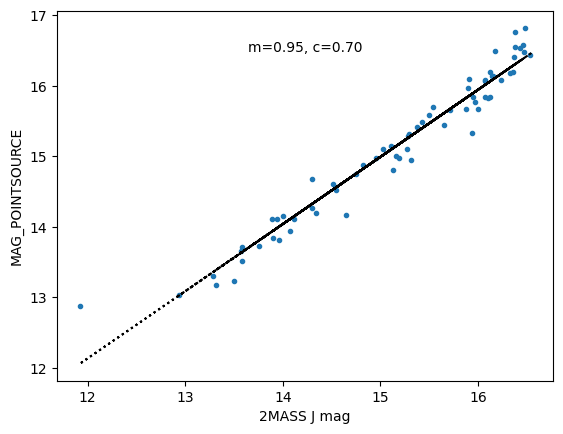

In [19]:
for key, (cat, ref) in all_xmatch.items():
    zp = all_zps[key]
    plt.figure()
    x = ref['j_m']
    y = cat['MAG_POINTSOURCE'] + zp
    plt.plot(x, y, '.')

    (m, c) = line_fit(x, y)

    plt.annotate(
        f"m={m:.2f}, c={c:.2f}",
        xy=(0.5, 0.9),
        xycoords='axes fraction',
        ha='center',  
        va='center',
    )
    
    plt.plot(x, m*x + c, linestyle=":", color="k")
    plt.ylabel('MAG_POINTSOURCE')
    plt.xlabel('2MASS J mag')
    plt.savefig(out_dir / f"scatter_ps_{key}.pdf")

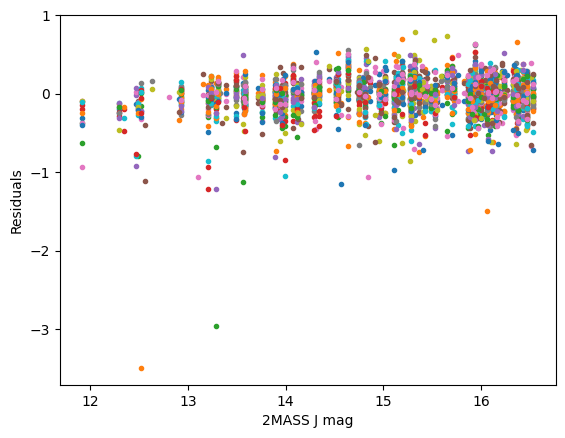

In [20]:
res_df_ps = []

for (cat, ref) in all_xmatch.values():
    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(cat['MAG_POINTSOURCE'], ref['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = ref['j_m'] - cat['MAG_POINTSOURCE'] - zp
    plt.plot(ref['j_m'], residuals, '.')
    res_df_ps.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars
    })

res_df_ps = pd.DataFrame(res_df_ps)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_ps.pdf")

Median: -0.00, std: 0.23 
 ZP: 25.87, zpstd 0.05, nstars: 1247


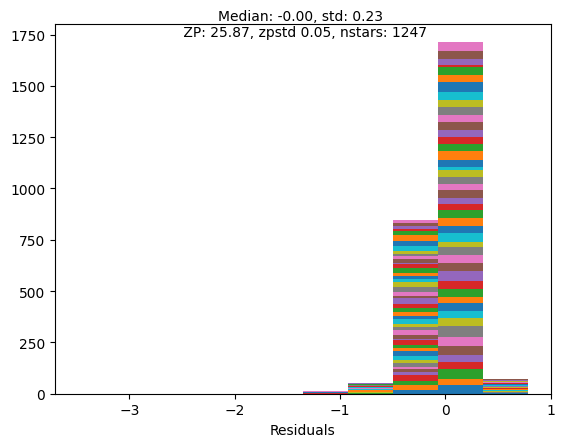

In [21]:
plt.hist(res_df_ps["residuals"], stacked=True)
all_residuals = [x for y in res_df_ps["residuals"] for x in y]
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_ps["zp"].median():.2f}, zpstd {res_df_ps["zpstd"].median():.2f}, nstars: {res_df_ps["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_ps.pdf",
    bbox_inches="tight",
)

In [22]:
cat

<Table length=67>
ALPHAWIN_J2000 DELTAWIN_J2000   X_IMAGE   ... FLUX_APER_7 MAG_APER_8 FLUX_APER_8
     deg            deg           pix     ...                                   
   float64        float64       float32   ...   float32    float32     float32  
-------------- -------------- ----------- ... ----------- ---------- -----------
   178.9869711     42.8453423   1718.5913 ...   11760.127 -10.164177   11632.435
   178.9991013     42.7679538   1688.6212 ...   268990.16 -13.590247   272959.84
   179.0056948     42.7768241   1672.9481 ...    4712.649  -9.160461    4615.137
   179.0122090     42.5889719   1658.8823 ...    9747.293 -9.9876175    9886.601
   179.0261777     42.8694000   1625.2377 ...   12380.509  -10.24915   12579.406
   179.0290436     42.6217130   1617.6420 ...    90414.43 -12.390629    90417.29
   179.0350013     42.8568621   1603.8152 ...   17453.465 -10.598482   17353.734
   179.0367086     42.7427583   1598.4193 ...    11259.53 -10.127159   11242.521
   179.0459158     42.6366538   1576.8212 ...   31081.592 -11.236396   31229.006
           ...            ...         ... ...         ...        ...         ...
   179.5449434     42.6911459    390.0399 ...    74680.73  -12.18809    75030.17
   179.5669480     42.8305955    339.6203 ...   10639.981 -10.122243   11191.728
   179.5713718     42.7141007    326.6168 ...    52224.71 -11.816989   53308.395
   179.5725216     42.6885026    322.8245 ...    67200.87 -12.089348    68507.65
   179.5850045     42.7257788    293.9022 ...   65730.836 -12.059965   66678.555
   179.6010334     42.8057586    256.5271 ...   13936.142 -10.391484   14341.468
   179.6242536     42.7811312    198.9673 ...   7666.4106  -9.763404     8041.95
   179.6450987     42.8022437    147.6171 ...   45091.586  -11.66161   46200.184
   179.6555624     42.8676239    121.4169 ...   16109.166  -10.53385   16350.827

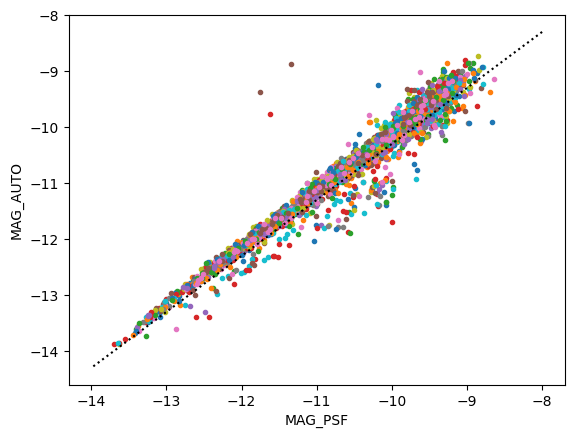

In [23]:
for (cat, ref) in all_xmatch.values():
    plt.plot(cat['MAG_PSF'], cat['MAG_AUTO'], '.')
plt.plot([-8., -14.], np.array([-8., -14.])-0.3, linestyle=":", color="k") 
plt.xlabel("MAG_PSF")
plt.ylabel("MAG_AUTO")
plt.savefig(out_dir / "auto_psf.pdf")

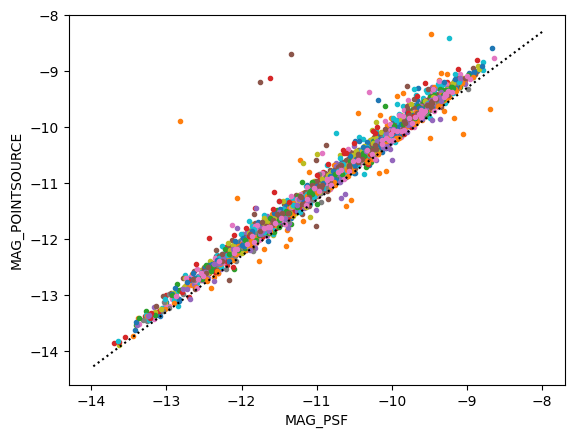

In [24]:
for (cat, ref) in all_xmatch.values():
    plt.plot(cat['MAG_PSF'], cat['MAG_POINTSOURCE'], '.')
plt.plot([-8., -14.], np.array([-8., -14.])-0.3, linestyle=":", color="k") 
plt.xlabel("MAG_PSF")
plt.ylabel("MAG_POINTSOURCE")
plt.savefig(out_dir / "ps_psf.pdf")

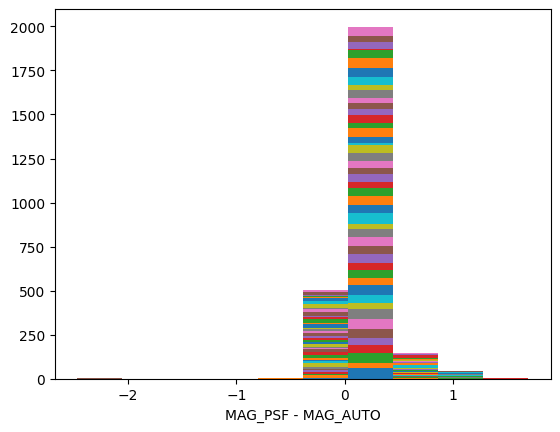

In [25]:
ratios = []
for (cat, ref) in all_xmatch.values():
    ratios.append(cat['MAG_PSF'] - cat['MAG_AUTO'])
plt.hist(ratios, stacked=True)
plt.xlabel("MAG_PSF - MAG_AUTO")
plt.savefig(out_dir / "auto_psf_hist.pdf")

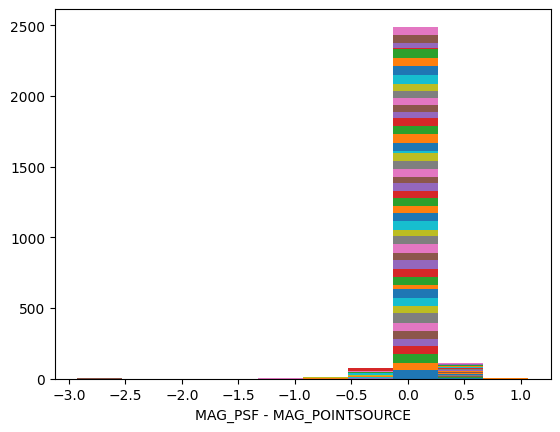

In [26]:
ratios = []
for (cat, ref) in all_xmatch.values():
    ratios.append(cat['MAG_PSF'] - cat['MAG_POINTSOURCE'])
plt.hist(ratios, stacked=True)
plt.xlabel("MAG_PSF - MAG_POINTSOURCE")
plt.savefig(out_dir / "auto_psf_hist.pdf")

In [27]:
from astropy.coordinates import SkyCoord
from astropy import units as u

def get_catalog_mags(crd: SkyCoord, cat, colname: str = 'MAG_AUTO', errcolname: str = 'MAGERR_AUTO'):
    cat_crds = SkyCoord(cat['ALPHAWIN_J2000'], cat['DELTAWIN_J2000'], unit=u.deg)
    idx, sep, _ = crd.match_to_catalog_sky(cat_crds)
    return cat[idx][colname], cat[idx][errcolname], cat[idx][colname.replace('MAG', 'FLUX')], cat[idx][errcolname.replace('MAG', 'FLUX')], cat[idx]['XWIN_IMAGE'], cat[idx]['YWIN_IMAGE'], sep.to(u.arcsec).value

def get_catalog_mags_from_list(crds, catlist, colname: str= 'MAG_AUTO', errcolname: str= 'MAGERR_AUTO', add_zp=True):
    mags = []
    magerrs = []
    fluxes = []
    fluxerrs = []
    xs, ys = [], []
    seps = []
    for (cat, zp) in catlist:
        mag, magerr, flux, fluxerr, x, y, sep = get_catalog_mags(crds, cat, colname=colname, errcolname=errcolname)
        if add_zp:
            mag += zp
        mags.append(mag)
        magerrs.append(magerr)
        fluxes.append(flux)
        fluxerrs.append(fluxerr)
        xs.append(x)
        ys.append(y)
        seps.append(sep)
    mags = np.array(mags)
    magerrs = np.array(magerrs)
    fluxes = np.array(fluxes)
    fluxerrs = np.array(fluxerrs)
    xs = np.array(xs)
    ys = np.array(ys)

    matchmask = np.array(seps)<2
    mags[~matchmask] = np.nan
    magerrs[~matchmask] = np.nan
    fluxes[~matchmask] = np.nan
    fluxerrs[~matchmask] = np.nan
    xs[~matchmask] = np.nan
    ys[~matchmask] = np.nan

    return mags, magerrs, fluxes, fluxerrs, xs, ys, seps


In [28]:
cats = [(x, all_zps[k]) for k, (x, _) in all_xmatch.items()]
ref_cat = ref

In [29]:
bright_ref_cat = ref_cat
# bright_ref_cat = bright_ref_cat[(bright_ref_cat['j_m']<14) & (bright_ref_cat['j_m']>13)]
bright_ref_cat_crds = SkyCoord(ra=bright_ref_cat['ra'], dec=bright_ref_cat['dec'], unit=(u.deg, u.deg))

In [30]:
bright_ref_cat

<Table length=67>
    RA_ICRS         DE_ICRS           Source       ... ra_errdeg dec_errdeg
      deg             deg                          ...    mas       mas    
    float64         float64           int64        ...  float64   float64  
--------------- --------------- ------------------ ... --------- ----------
178.98724494444  42.84537645097 769702261642786304 ...    0.0000     0.0000
178.99910980274  42.76794576996 768950298768804096 ...    0.0000     0.0000
179.00571913003  42.77674451200 768950298768803840 ...    0.0000     0.0000
179.01235003977  42.58908089598 768932912741189120 ...    0.0000     0.0000
179.02633278445  42.86940049911 769702673959651584 ...    0.0000     0.0000
179.02908877292  42.62168847893 768934115332031872 ...    0.0000     0.0000
179.03509465911  42.85687163712 768951982395983488 ...    0.0000     0.0000
179.03652821460  42.74267144531 768947373895511040 ...    0.0000     0.0000
179.04584551260  42.63666686552 768934149691769984 ...    0.0000     0.0000
            ...             ...                ... ...       ...        ...
179.54488724427  42.69113483209 768908723485366656 ...    0.0000     0.0000
179.56698551282  42.83063851902 768958373306649600 ...    0.0000     0.0000
179.57135463431  42.71409281104 768909170161965056 ...    0.0000     0.0000
179.57254073779  42.68849848327 768908895284057984 ...    0.0000     0.0000
179.58502278119  42.72581830253 768909204521703168 ...    0.0000     0.0000
179.60108515149  42.80581144287 768957411234633216 ...    0.0000     0.0000
179.62432353758  42.78116763113 768910372752806144 ...    0.0000     0.0000
179.64509688134  42.80223682222 768916316987543424 ...    0.0000     0.0000
179.65554872999  42.86751481221 768964351901766912 ...    0.0000     0.0000

# MAG_AUTO

Text(0.5, 0, 'Frame #')

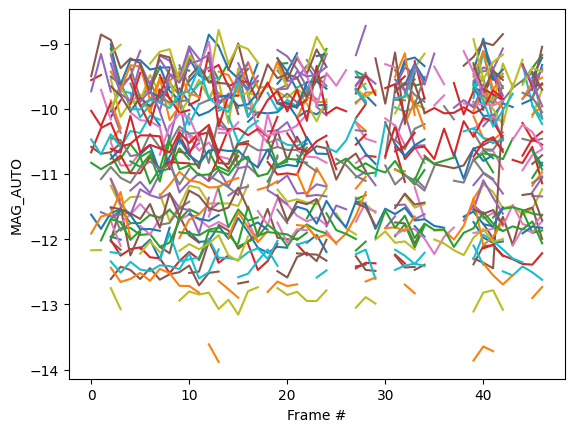

In [31]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, add_zp=False)
plt.plot(mags)
plt.ylabel(r'MAG_AUTO')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (AUTO)')

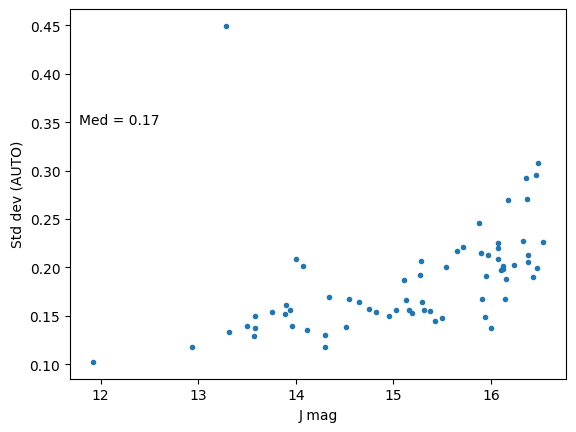

In [32]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (AUTO)')

Text(0.5, 0, 'Frame #')

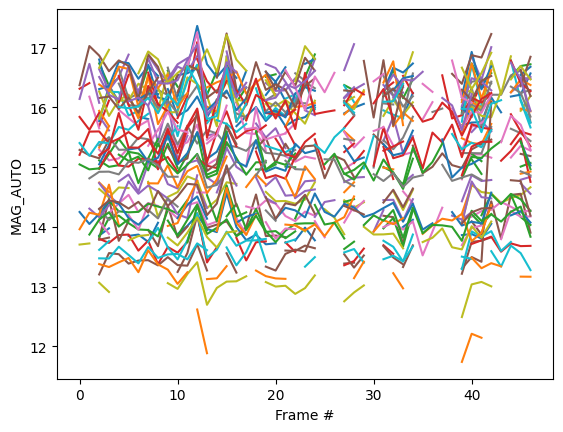

In [33]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, add_zp=True)
plt.plot(mags)
plt.ylabel(r'MAG_AUTO')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (AUTO)')

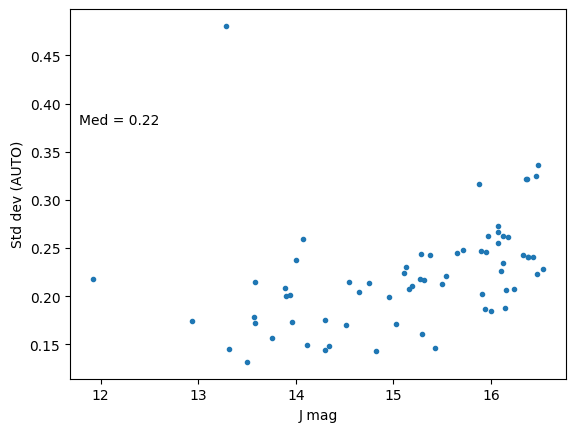

In [34]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (AUTO)')

# MAG_PSF

Text(0.5, 0, 'Frame #')

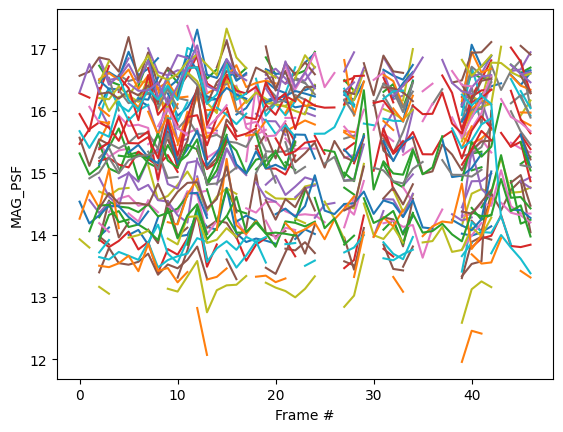

In [35]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname="MAG_PSF")
plt.plot(mags)
plt.ylabel(r'MAG_PSF')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (PSF)')

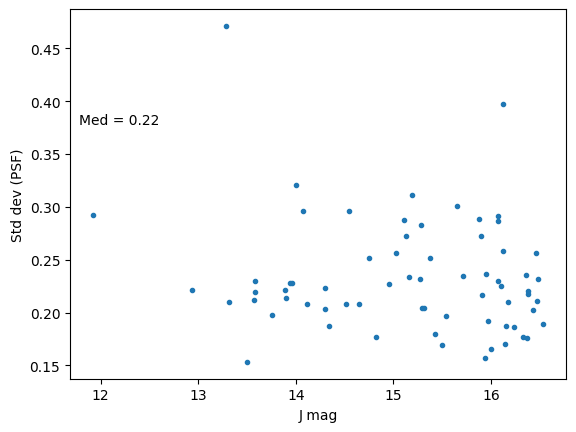

In [36]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (PSF)')

# MAG_POINTSOURCE

Text(0.5, 0, 'Frame #')

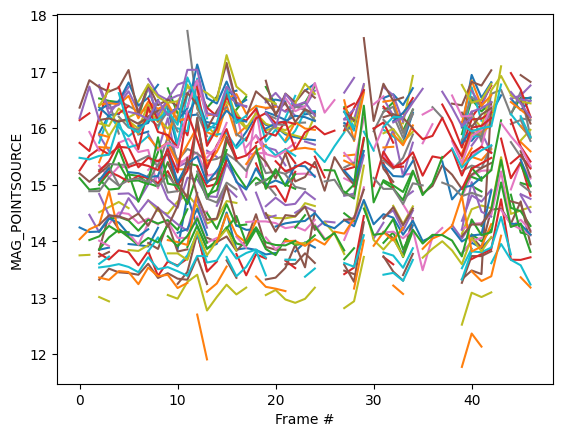

In [37]:
mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname="MAG_POINTSOURCE")
plt.plot(mags)
plt.ylabel(r'MAG_POINTSOURCE')
plt.xlabel(r'Frame #')

Text(0, 0.5, 'Std dev (PS)')

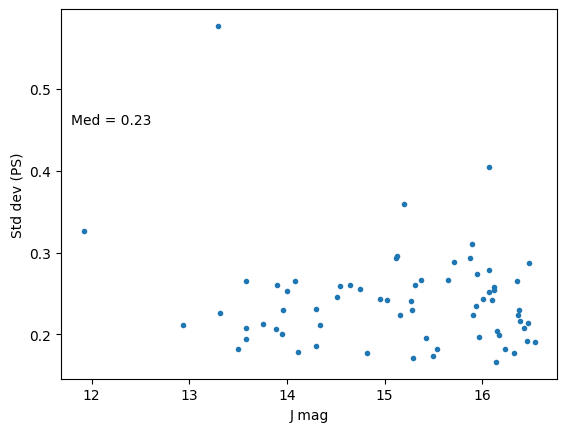

In [38]:
stds = np.nanstd(mags, axis=0)
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.median(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (PS)')

# MAG_APER

In [39]:
for ap in APER_RANGE:
    var = f'MAG_APER_{ap}'

    mags, magerrs, fluxes, fluxerrs, xs, ys, seps = get_catalog_mags_from_list(bright_ref_cat_crds, cats, colname=var)
    stds = np.nanstd(mags, axis=0)

    med = f"Med = {np.median(stds):.2f}"

    print(var, med)


MAG_APER_2 Med = 0.22
MAG_APER_3 Med = 0.20
MAG_APER_4 Med = 0.20
MAG_APER_5 Med = 0.21
MAG_APER_6 Med = 0.21
MAG_APER_7 Med = 0.22
MAG_APER_8 Med = 0.22


In [40]:
def perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates.
    :param image:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    image_data = fits.getdata(image)
    wcs = WCS(fits.getheader(astrometry_image))
    # Convert coordinates to pixel coordinates
    crds = crds.to_pixel(wcs)
    xs = crds[0]
    ys = crds[1]
    apertures = CircularAperture(np.column_stack((xs, ys)), r=aper_radius)
    # annulus_apertures = CircularAnnulus(np.column_stack((xs, ys)), r_in=annulus_bkg_in, r_out=annulus_bkg_out)

    bkg = Background2D(image_data, box_size=(50, 50), filter_size=(3, 3), **kwargs)
    bkg_mean = bkg.background_median
    # bkg_tab = aperture_photometry(image_data, annulus_apertures)

    # annulus_mask = annulus_apertures.to_mask(method='center')
    # annulus_bkg_data = annulus_mask[0].multiply(image_data)
    # annulus_bkg_median = np.nanmedian(annulus_bkg_data[annulus_bkg_data > 0])
    # phot_table_annulus = aperture_photometry(image_data - annulus_bkg_median, apertures)
    # Perform aperture photometry
    phot_table = aperture_photometry(image_data - bkg_mean, apertures, mask=np.isnan(image_data))

    return phot_table # phot_table_annulus

def perform_aperture_photometry_in_multiple_images(image_list, astrometry_image_list, crds, aper_radius=5, annulus_bkg_in=10, annulus_bkg_out=15, **kwargs):
    """
    Perform aperture photometry on a list of coordinates for a list of images.
    :param image_list:
    :param astrometry_image_list:
    :param crds:
    :param aper_radius:
    :param annulus_bkg_in:
    :param annulus_bkg_out:
    :return:
    """
    phot_table_list = []
    for ind, image in enumerate(image_list):
        astrometry_image = astrometry_image_list[ind]
        phot_table = perform_aperture_photometry_on_coordinates(image, astrometry_image, crds, aper_radius, annulus_bkg_in, annulus_bkg_out, **kwargs)
        phot_table_list.append(phot_table)

    # Add image name to phot_table
    for ind, phot_table in enumerate(phot_table_list):
        phot_table['image'] = os.path.basename(image_list[ind])
        phot_table['astrometry_image'] = os.path.basename(astrometry_image_list[ind])

    # Make final table
    phot_table_list = np.hstack(phot_table_list)
    phot_table_df = pd.DataFrame(phot_table_list)
    return phot_table_df

def plot_aperture_phot_on_list(imagelist, astrometry_list, crds, aper_radius=5, **kwargs):
    phot_table = perform_aperture_photometry_in_multiple_images(imagelist, astrometry_list, crds, aper_radius=aper_radius, **kwargs)
    phot_table_grps = phot_table.groupby('id')
    std_values = []
    plt.figure()
    for name, group in phot_table_grps:
        mags = -2.5*np.log10(group['aperture_sum'].values)
        plt.plot(mags, label=name)
        std_values.append(np.nanstd(mags))

    return std_values, phot_table

In [41]:
imgs = list((target_dir.parent / "final").glob("WINTER*0.fits"))
imgs

[PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-122940-298_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-101904-287_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-123355-104_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-112406-465_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-125733-472_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-102734-068_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-063726-389_mef_4_0_0.fits'),
 PosixPath('/Users/rdstein/Data/observing/winter/20240309_C2MNLC/final/WINTERcamera_20240310-064352-057_mef_4_0_0.fits'),
 PosixPath('/Users/rdste

In [42]:
# from astropy.io import fits

# for img_path in imgs:
#     with fits.open(img_path) as hdul:
#         print(hdul[0].header["TOBPORT"])

/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_17104/3795233498.py:66: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1867: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_17104/3795233498.py:66: RuntimeWarning: invalid value encountered in log10
  mags = -2.5*np.log10(group['aperture_sum'].values)


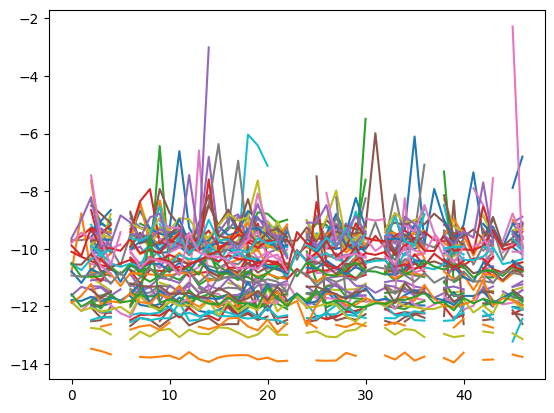

In [43]:
stds, df = plot_aperture_phot_on_list(imgs, imgs, bright_ref_cat_crds)

Text(0, 0.5, 'Std dev (FORCED_APER)')

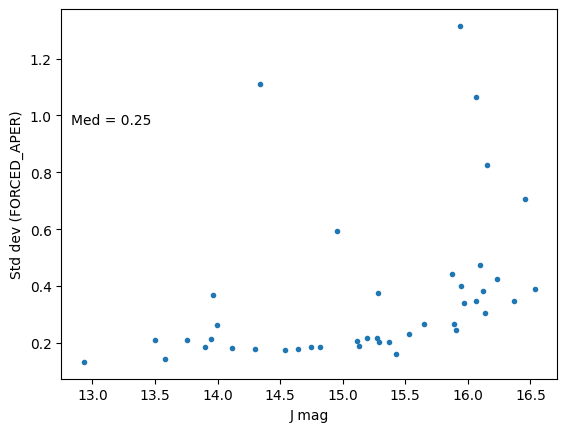

In [44]:
plt.plot(bright_ref_cat['j_m'], stds, '.')
plt.annotate(
    f"Med = {np.nanmedian(stds):.2f}",
    xy=(0.1, 0.7),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel(r'J mag')
plt.ylabel(r'Std dev (FORCED_APER)')

In [45]:
df

id      xcenter     ycenter   aperture_sum  \
0      1  1712.227535  131.373175   11149.739504   
1      2  1682.652007  382.578362  284397.126888   
2      3  1666.855005  354.231648    3434.695588   
3      4  1652.680496  963.579911    9402.098340   
4      5  1619.086488   54.489251   13004.489427   
...   ..          ...         ...            ...   
3144  63   284.201235  523.224559   54593.955714   
3145  64   246.466360  262.858474   19652.591936   
3146  65   188.991955  342.878124    9362.711916   
3147  66   137.727152  273.738531   47613.942110   
3148  67   111.104483   59.223683   13095.578114   

                                                image  \
0     WINTERcamera_20240310-122940-298_mef_4_0_0.fits   
1     WINTERcamera_20240310-122940-298_mef_4_0_0.fits   
2     WINTERcamera_20240310-122940-298_mef_4_0_0.fits   
3     WINTERcamera_20240310-122940-298_mef_4_0_0.fits   
4     WINTERcamera_20240310-122940-298_mef_4_0_0.fits   
...                                               ...   
3144  WINTERcamera_20240310-111536-167_mef_4_0_0.fits   
3145  WINTERcamera_20240310-111536-167_mef_4_0_0.fits   
3146  WINTERcamera_20240310-111536-167_mef_4_0_0.fits   
3147  WINTERcamera_20240310-111536-167_mef_4_0_0.fits   
3148  WINTERcamera_20240310-111536-167_mef_4_0_0.fits   

                                     astrometry_image  
0     WINTERcamera_20240310-122940-298_mef_4_0_0.fits  
1     WINTERcamera_20240310-122940-298_mef_4_0_0.fits  
2     WINTERcamera_20240310-122940-298_mef_4_0_0.fits  
3     WINTERcamera_20240310-122940-298_mef_4_0_0.fits  
4     WINTERcamera_20240310-122940-298_mef_4_0_0.fits  
...                                               ...  
3144  WINTERcamera_20240310-111536-167_mef_4_0_0.fits  
3145  WINTERcamera_20240310-111536-167_mef_4_0_0.fits  
3146  WINTERcamera_20240310-111536-167_mef_4_0_0.fits  
3147  WINTERcamera_20240310-111536-167_mef_4_0_0.fits  
3148  WINTERcamera_20240310-111536-167_mef_4_0_0.fits  

[3149 rows x 6 columns]

/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/winterdrp_offline/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **

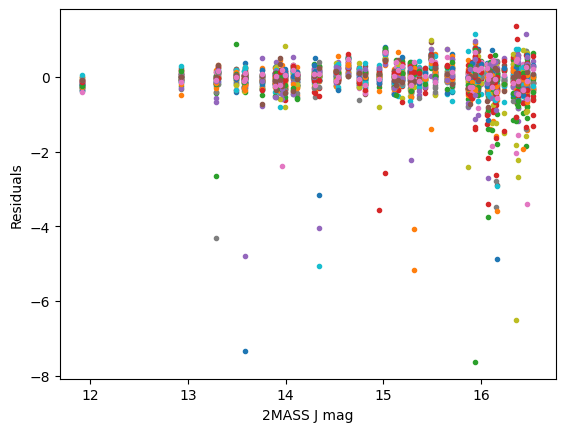

In [46]:
list(all_xmatch.keys())

res_df_forced = []

for key, (cat, ref) in all_xmatch.items():
    name = str(Path(key).with_suffix(".fits"))

    mask = df["image"] == name
    
    mags = -2.5 * np.log10(df["aperture_sum"][mask])

    zp, zpstd, nstars = calculate_zeropoint_outlier_rejection(mags, bright_ref_cat['j_m'], outlier_rejection_thresholds=[1.5])
    residuals = bright_ref_cat['j_m'] - mags - zp
    plt.plot(bright_ref_cat['j_m'], residuals, '.')
    res_df_forced.append({
        "residuals": [float(x) for x in residuals],
        "zp": zp,
        "zpstd": zpstd,
        "nstars": nstars,
    })

res_df_forced = pd.DataFrame(res_df_forced)
plt.ylabel('Residuals')
plt.xlabel('2MASS J mag')
plt.savefig(out_dir / "residuals_forced.pdf")

Median: -0.01, std: 0.53 
 ZP: 25.86, zpstd 0.09, nstars: 1263


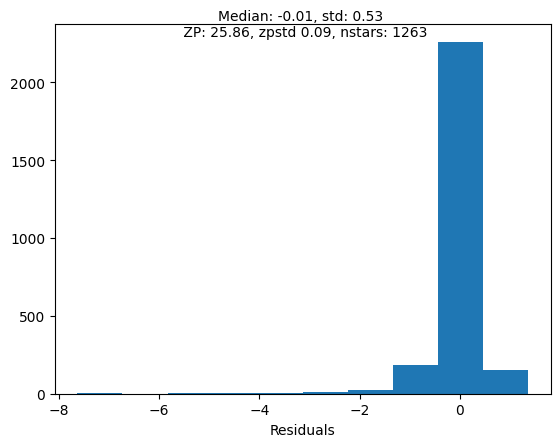

In [47]:
all_residuals = [x for y in res_df_forced["residuals"] for x in y if pd.notnull(x) & np.isfinite(x)]
plt.hist(all_residuals)
txt = (f"Median: {np.median(all_residuals):.2f}, std: {np.std(all_residuals):.2f} \n ZP: {res_df_forced["zp"].median():.2f}, zpstd {res_df_forced["zpstd"].median():.2f}, nstars: {res_df_forced["nstars"].sum()}")
print(txt)
plt.annotate(
    txt,
    xy=(0.5, 1.0),
    xycoords='axes fraction',
    ha='center',  
    va='center',
)
plt.xlabel("Residuals")
plt.savefig(
    out_dir / "hist_forced.pdf",
    bbox_inches="tight",
)

In [48]:
# results = dict()
# results[